

# Trabajo Fin de Grado

# Predicción de los Precios de las Viviendas en Madrid Capital

# Grado en Estadística y Empresa - Curso 2023/2024

# Andrés Rubio Lafuente


# Índice

El trabajo se divide en 6 partes:
1. PAQUETES
2. ETL
3. EDA
4. PREPROCESO
5. APRENDIZAJE SUPERVISADO
6. APRENDIZAJE NO SUPERVISADO

## 1. PAQUETES

Instalamos los paquetes necesarios.

In [1]:
!pip install graphviz

Cargamos los paquetes necesarios para realizar el trabajo.

In [2]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import scipy.stats as stats

# Funciones Personalizadas
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/TFG/Trabajo')
import importlib
import paquete_funciones_tfg as func_tfg
importlib.reload(func_tfg)

# Preproceso
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Aprendizaje Supervisado
import graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

# Aprendizaje No Supervisado
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.stats import t

# Tiempo de Ejecución y Advertencias
import time
import warnings
warnings.simplefilter("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. ETL

Cargamos los datos de las viviendas, que se encuentran en un archivo csv y cambiamos el nombre de la variable que contiene los distritos que está clasificada como 'distrito'.

In [3]:
url = 'https://raw.githubusercontent.com/rbooantt/PROYECTOS-UNI/main/datos%20(3).csv?token=GHSAT0AAAAAACQKBZJUCRF3MHKNRUR6JROKZQWZYGQ'
datos = pd.read_csv(url, usecols = lambda x: x != 'Unnamed: 0')
datos.rename(columns = {'barrio': 'distrito'}, inplace = True)
datos.head()

,direccion,distrito,precio,piscina,terraza,jardin,garaje,trastero,calefaccion,aire_acondicionado,ascensor,superficie_construida,habitaciones,baños,planta,inmobiliaria
0,"Piso en venta en Calle de Sondica, 1",Las Aguilas (Distrito Latina. Madrid Capital),A consultar,no,no,no,no,no,no,no,no,71 metros cuadrados,NaN,NaN,NaN,ALTAMIRA
1,"Piso en venta en Calle de Francisco Lizcano, 20",Buenavista (Distrito Carabanchel. Madrid Capital),265.000 euros,no,si,si,si,si,si,si,si,91 metros cuadrados,2.0,2.0,1a,Jose Carlos Yanez
2,"Piso en venta en Calle Gaztambide, 81, cerca d...",Vallehermoso (Distrito Chamberi. Madrid Capital),515.000 euros,no,no,no,no,no,si,no,si,78 metros cuadrados,2.0,1.0,2a,CASA 10 ASESORES
3,Piso en venta en San Pascual,San Pascual (Distrito Ciudad Lineal. Madrid Ca...,230.000 euros,si,no,si,no,no,no,si,si,39 metros cuadrados,1.0,1.0,2a,RIVE
4,Piso en venta en Calle de Pizarro,Universidad-Malasana (Distrito Centro. Madrid ...,1.370.000 euros,no,no,no,no,no,si,si,si,300 metros cuadrados,2.0,2.0,3a,STUDIOS Y PROYECTOS MADRID (SYPMADRID)


Cambiamos el formato de la variable **direccion** para que se quede con el tipo de vivienda y elimine el resto de informacion.

In [4]:
datos['direccion'] = datos['direccion'].str.extract(r'^(\w+)')
datos.rename(columns = {'direccion': 'tipo_vivienda'}, inplace = True)

Debemos cambiar el formato de algunas variables para poder trabajar con los datos correctamente.

Las variables **"precio"**, **"superficie_construida"**, **"habitaciones"** y **"baños"**  tomarán un formato de número entero.

Comenzamos cambiando el formato de la variable **"precio"** y eliminando las variables con valores faltantes.

In [5]:
datos['precio'] = datos['precio'].str.replace(' euros','').str.replace('.','')
datos['precio'] = func_tfg.nulos(datos, 'precio')

Las filas a eliminar son: [0, 19, 198, 266, 404, 492, 503, 653, 656, 901, 1348, 1414, 1734, 2102, 2419, 2534, 2885], pues toman valores {'A consultar', nan}.
En total se eliminan 17 filas del conjunto de datos por la variable precio.


Cambiamos ahora el formato de la variable **"superficie construida"**, pero no eliminamos los valores faltantes.

In [6]:
datos['superficie_construida'] = datos['superficie_construida'].str.replace(' metros cuadrados','').str.replace('.','')
datos['superficie_construida'] = func_tfg.nulos_texto(datos, 'superficie_construida')

Las filas con valores faltantes son : [961, 2150, 2430], pues toman valores {nan}.
En total hay 3 filas con valores faltantes del conjunto de datos para la variable superficie_construida.
La variable superficie_construida es del tipo: float64


Cambiamos ahora el formato de la variable **"habitaciones"**, pero no eliminamos los valores faltantes.

In [7]:
datos['habitaciones'] = func_tfg.nulos_texto(datos, 'habitaciones')

Las filas con valores faltantes son : [27, 59, 62, 107, 139, 180, 224, 238, 245, 250, 252, 316, 317, 340, 342, 346, 348, 352, 358, 399, 436, 437, 439, 447, 448, 449, 475, 479, 579, 582, 592, 602, 625, 672, 691, 720, 722, 723, 724, 725, 794, 860, 873, 874, 875, 876, 877, 878, 885, 900, 927, 1009, 1159, 1167, 1181, 1326, 1420, 1534, 1559, 1616, 1629, 1638, 1648, 1656, 1698, 1809, 1905, 1910, 1911, 1974, 1984, 2110, 2160, 2162, 2295, 2300, 2302, 2315, 2331, 2334, 2335, 2342, 2345, 2346, 2348, 2392, 2431, 2432, 2471, 2472, 2516, 2553, 2562, 2563, 2564, 2589, 2610, 2622, 2636, 2637, 2668, 2788, 2790, 2842, 2872], pues toman valores {nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

Cambiamos ahora el formato de la variable **"baños"**, pero no eliminamos los valores faltantes.

In [8]:
datos['baños'] = func_tfg.nulos_texto(datos, 'baños')

Las filas con valores faltantes son : [36, 58, 59, 62, 65, 107, 139, 171, 180, 219, 234, 238, 243, 245, 250, 252, 297, 316, 322, 346, 352, 399, 436, 437, 438, 439, 443, 447, 448, 449, 452, 479, 484, 485, 503, 522, 592, 602, 668, 670, 691, 720, 722, 723, 724, 725, 836, 837, 839, 842, 860, 873, 874, 875, 876, 877, 878, 885, 900, 927, 976, 977, 1024, 1085, 1095, 1127, 1181, 1269, 1313, 1332, 1344, 1629, 1630, 1653, 1656, 1716, 1756, 1791, 1798, 1822, 1862, 1910, 1911, 1952, 1956, 1957, 1984, 2001, 2295, 2300, 2302, 2315, 2331, 2334, 2335, 2348, 2431, 2432, 2442, 2516, 2548, 2553, 2562, 2563, 2589, 2610, 2620, 2668, 2674, 2695, 2788, 2862, 2872, 2892], pues toman valores {nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

Vamos a ver ahora la variable **"planta"**.

In [9]:
len(datos[datos['planta'].isna()])

1039

Decidimos eliminar la variable **"planta"** pues casi 1/3 de los datos son valores faltantes.

Estudiamos la variable **"inmobiliaria"**.

In [10]:
datos2 = datos.copy()
for i in range(0, len(datos2)):
  try:
      j = datos2['inmobiliaria'][i]
      if datos2['inmobiliaria'].value_counts()[j] < 20:
            datos2['inmobiliaria'][i] = 'independiente'
  except:
      datos2['inmobiliaria'][i] = 'independiente'
datos2['inmobiliaria'].value_counts()

inmobiliaria
independiente                        2294
Inmobiliaria recomendada               97
Aliseda Inmobiliaria.                  66
DIZA SOLUCIONES INMOBILIARIAS,S.L      57
HOGALIA Madrid                         53
donpiso Central                        52
VyP                                    52
VIVIENDA 2                             41
PREMIER ESPANA, S.A.                   32
Altor Asesores                         31
BM INVERSIONES                         31
UNICA INMOBILIARIA SL                  26
Gilmar Centro Madrid                   23
PRYGESA                                22
Gilmar Salamanca                       21
Linkcasa Servicios Inmobiliario        20
Name: count, dtype: int64

Se decide eliminar la variable **inmobiliaria** pues hay demasiadas inmobiliarias pequeñas y no proporciona información relevante.

In [11]:
datos.drop(['planta', 'inmobiliaria'], axis = 1, inplace = True)

Cambiamos el formato de la variable **distrito** para que se quede unicamente con el distrito y deseche el resto de caracteres.

In [12]:
datos['distrito'] = datos['distrito'].str.extract(r'Distrito\s(.*?)(?=\.)')

Identificamos las variables que son binarias y reordenamos las categorías.

In [13]:
var_bin = datos[['aire_acondicionado', 'calefaccion', 'ascensor', 'garaje', 'trastero', 'terraza', 'jardin', 'piscina']]
var_bin = var_bin.apply(lambda x: x.astype('category').cat.reorder_categories(['no', 'si']))
dic_var_bin = {'no': 0, 'si': 1}
for i in var_bin:
  datos[i].replace(dic_var_bin, inplace = True)

Guardamos los datos que nos quedan despues de realizar la ETL en un archivo csv.

In [14]:
url = "/content/drive/My Drive/TFG/Trabajo/datos_etl.csv"
datos.to_csv(url)

Cargamos los datos.

In [15]:
url = "/content/drive/My Drive/TFG/Trabajo/datos_etl.csv"
datos = pd.read_csv(url, usecols = lambda x: x != 'Unnamed: 0')
datos = pd.DataFrame(datos)
datos.head()

,tipo_vivienda,distrito,precio,piscina,terraza,jardin,garaje,trastero,calefaccion,aire_acondicionado,ascensor,superficie_construida,habitaciones,baños
0,Piso,Carabanchel,265000,0,1,1,1,1,1,1,1,91.0,2.0,2.0
1,Piso,Chamberi,515000,0,0,0,0,0,1,0,1,78.0,2.0,1.0
2,Piso,Ciudad Lineal,230000,1,0,1,0,0,0,1,1,39.0,1.0,1.0
3,Piso,Centro,1370000,0,0,0,0,0,1,1,1,300.0,2.0,2.0
4,Piso,Salamanca,1750000,0,0,0,0,0,0,0,0,105.0,2.0,2.0


## 3. EDA

### 3.1 Tratamiento de los Valores Atípicos

Lo primero que vamos a realizar es tratar con los valores que son demasiado extremos de forma que los podamos identificar y eliminar de nuestro conjunto de datos lo antes posible. De esta forma, la calidad de la visualización de los datos y el análisis exploratorio mejorarán notablemente.

Realizamos un diagrama de caja o boxplot para captar la presencia de valores atípicos o outliers de las variables numéricas según el distrito al que pertenezcan las viviendas.

Comenzamos realizando el boxplot para el precio de las viviendas según el distrito al que pertenezcan.

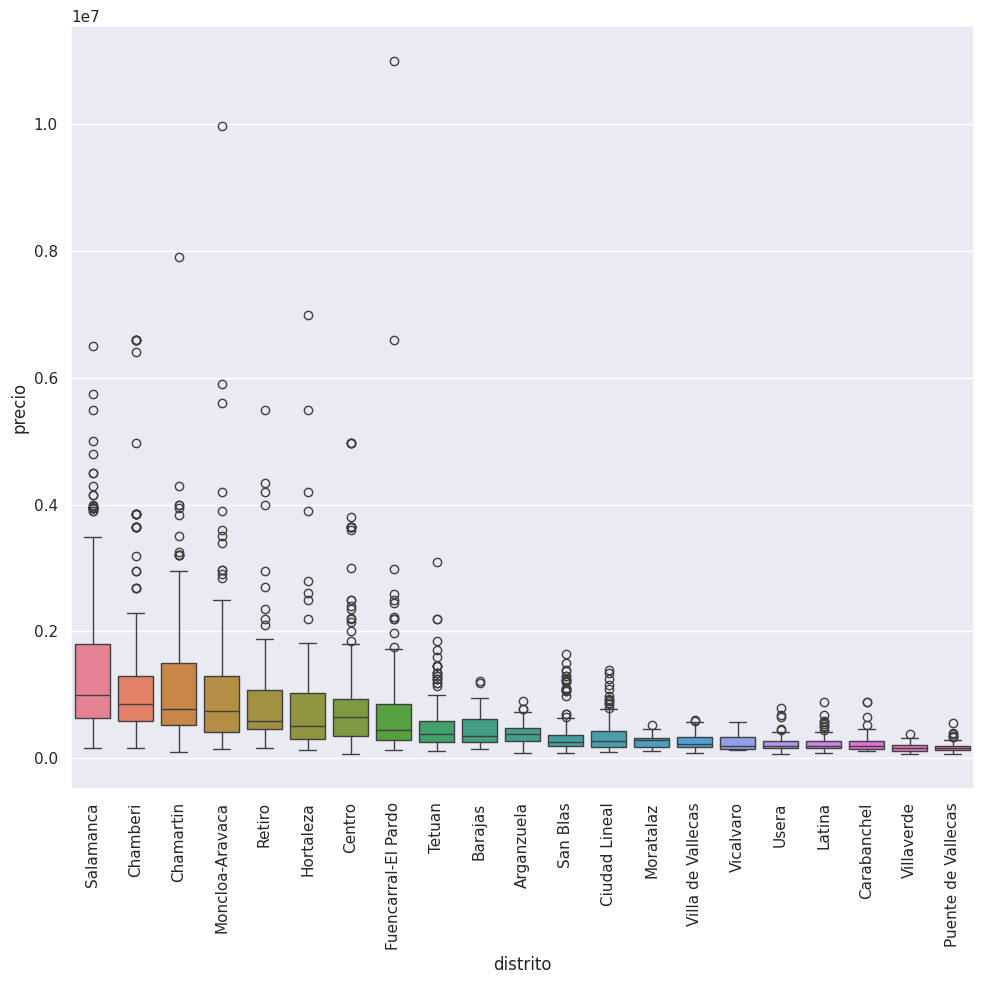

In [16]:
func_tfg.boxplot_num(datos, 'precio', 'distrito', 'precio')
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Valores Atipicos/Boxplot1precio.png')
plt.show()

Comenzamos realizando el boxplot para la superficie construida según el distrito al que pertenezcan.

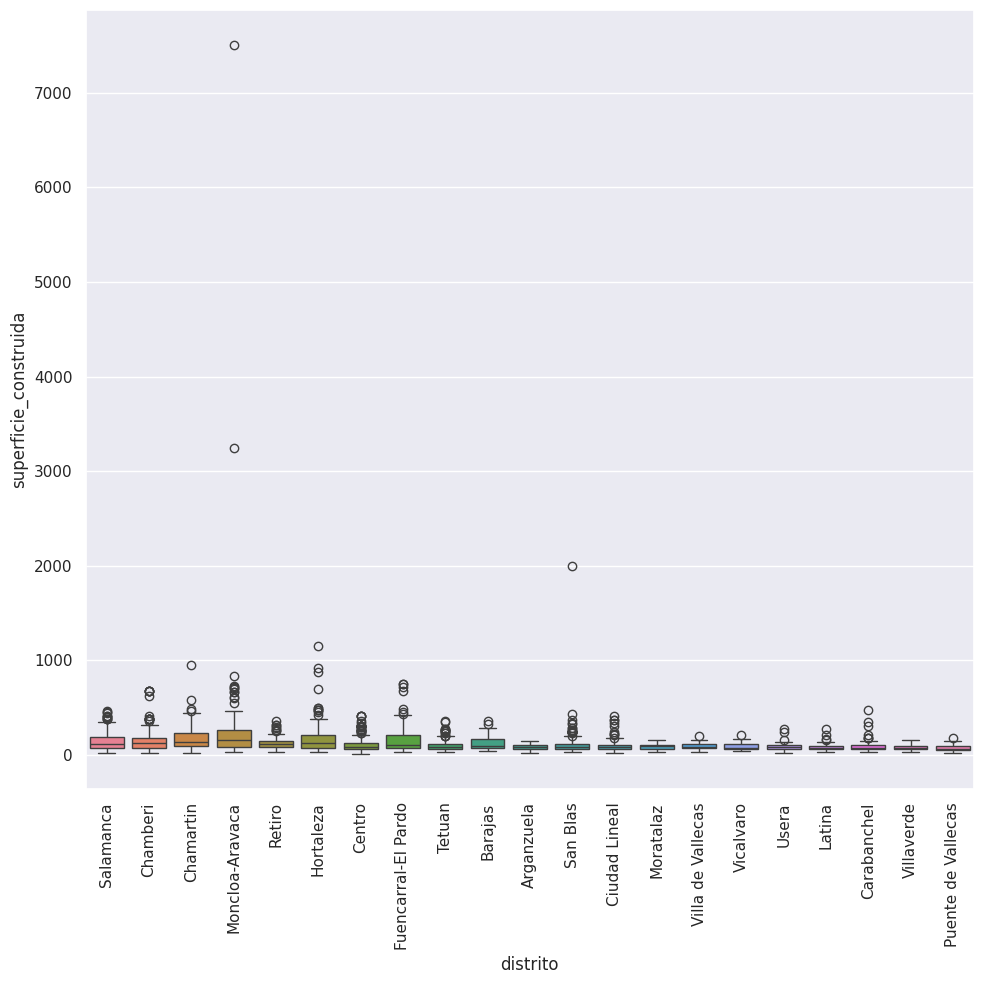

In [17]:
func_tfg.boxplot_num(datos, 'superficie_construida', 'distrito', 'precio')
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Valores Atipicos/Boxplot1superficie.png')
plt.show()

Comenzamos realizando el boxplot para el número de habitaciones según el distrito al que pertenezcan.

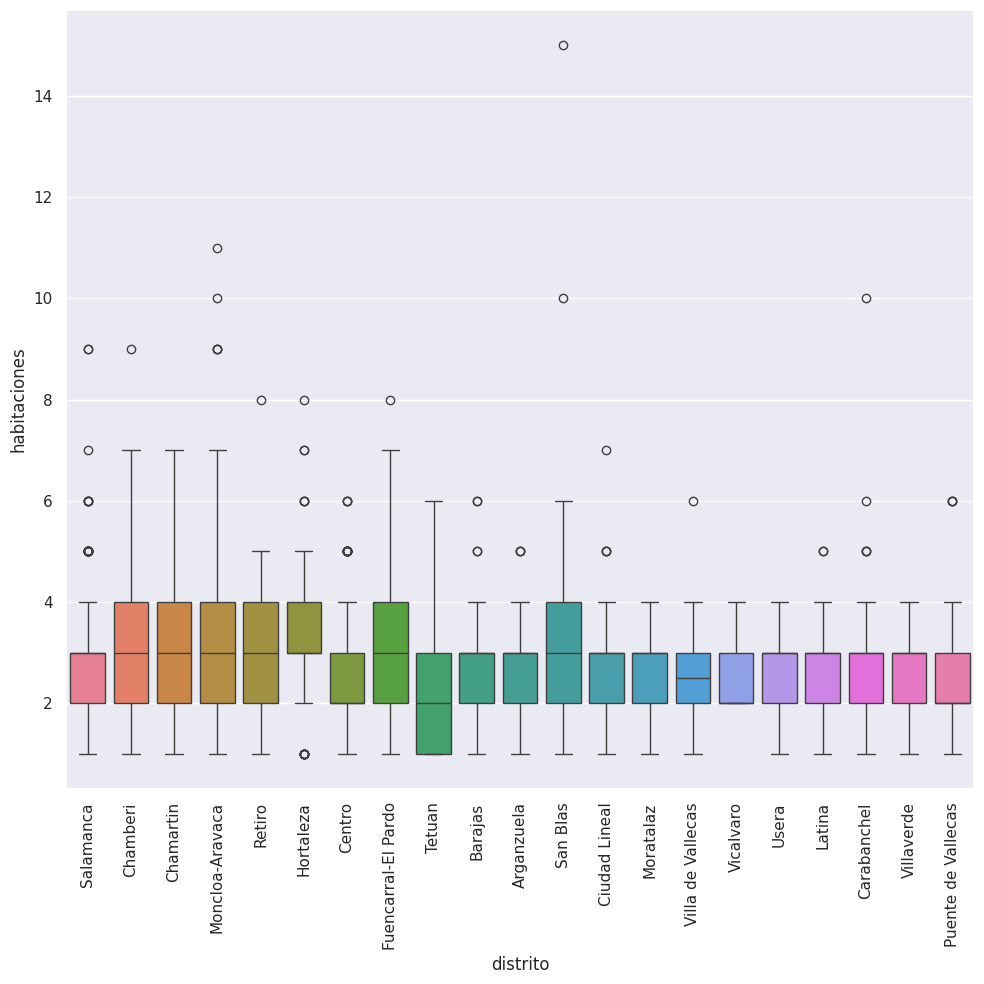

In [18]:
func_tfg.boxplot_num(datos, 'habitaciones', 'distrito', 'precio')
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Valores Atipicos/Boxplot1habitaciones.png')
plt.show()

Comenzamos realizando el boxplot para el número de baños según el distrito al que pertenezcan.

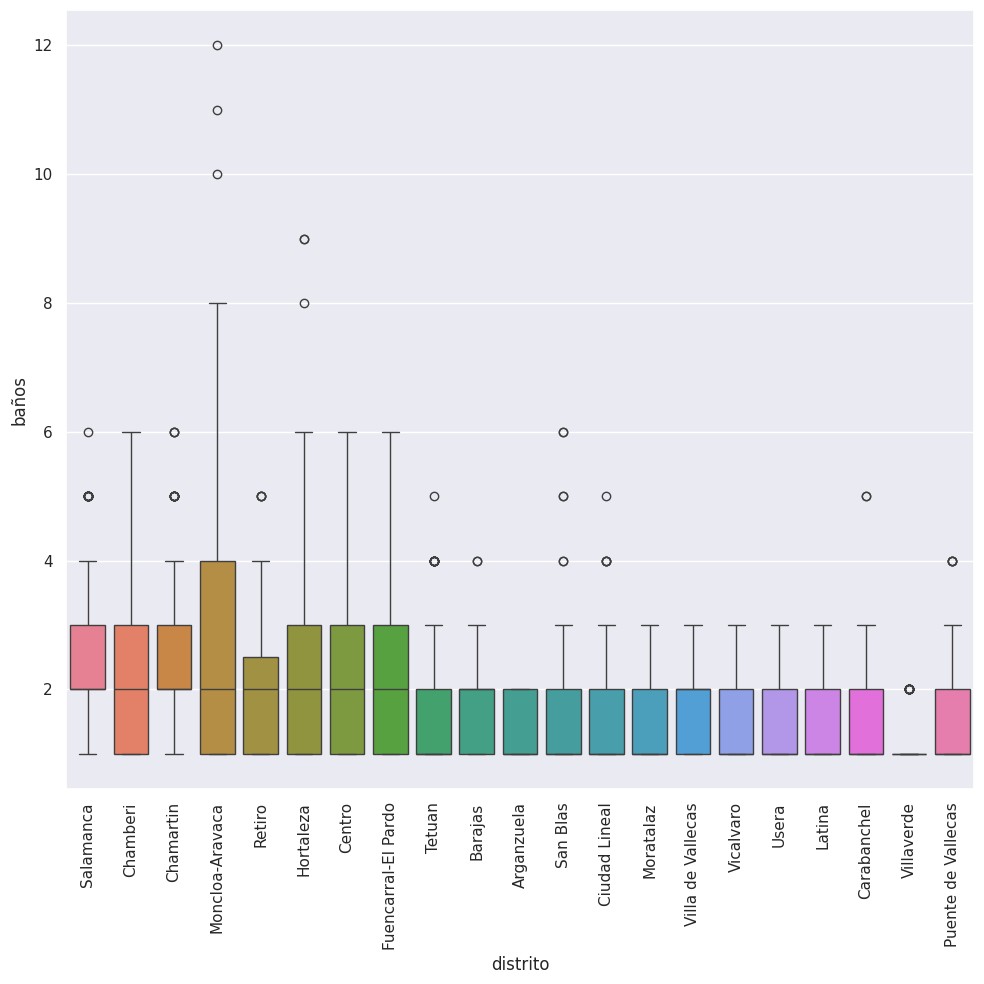

In [19]:
func_tfg.boxplot_num(datos, 'baños', 'distrito', 'precio')
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Valores Atipicos/Boxplot1baños.png')
plt.show()

Como vemos, tenemos algunos valores que son demasiado extremos con los que debemos tratar.

La regla de decisión que se toma es que se eliminan aquellos valores que sean mayores que **{Q3 + 3 * IQR}** o menores que **{Q1 - 3 * IQR}**.

Se deciden eliminar del conjunto de datos todos aquellos valores atípicos que son demasiado extremos considerando todas las variables numéricas exceptuando la variable **baños**.

No podemos considerar la variable **baños** pues para el distrito de Villaverde, obtenemos que Q1 = Q3 para el número de baños y IQR = 0 y entonces se eliminarían prácticamente todas las viviendas de este distrito

In [20]:
num = ['precio', 'superficie_construida', 'habitaciones']
b = datos.copy()
for i in num:
  datos_sin_atipicos = func_tfg.valores_atipicos(b, i, 'distrito')
  b = datos_sin_atipicos.copy()
datos_distrito_final = b.copy()


Una vez eliminados los valores muy extremos, se visualizan de nuevo los diagramas de caja de las variables numéricas en función del distrito.

Comenzamos realizando el boxplot para el precio de las viviendas según el distrito al que pertenezcan.

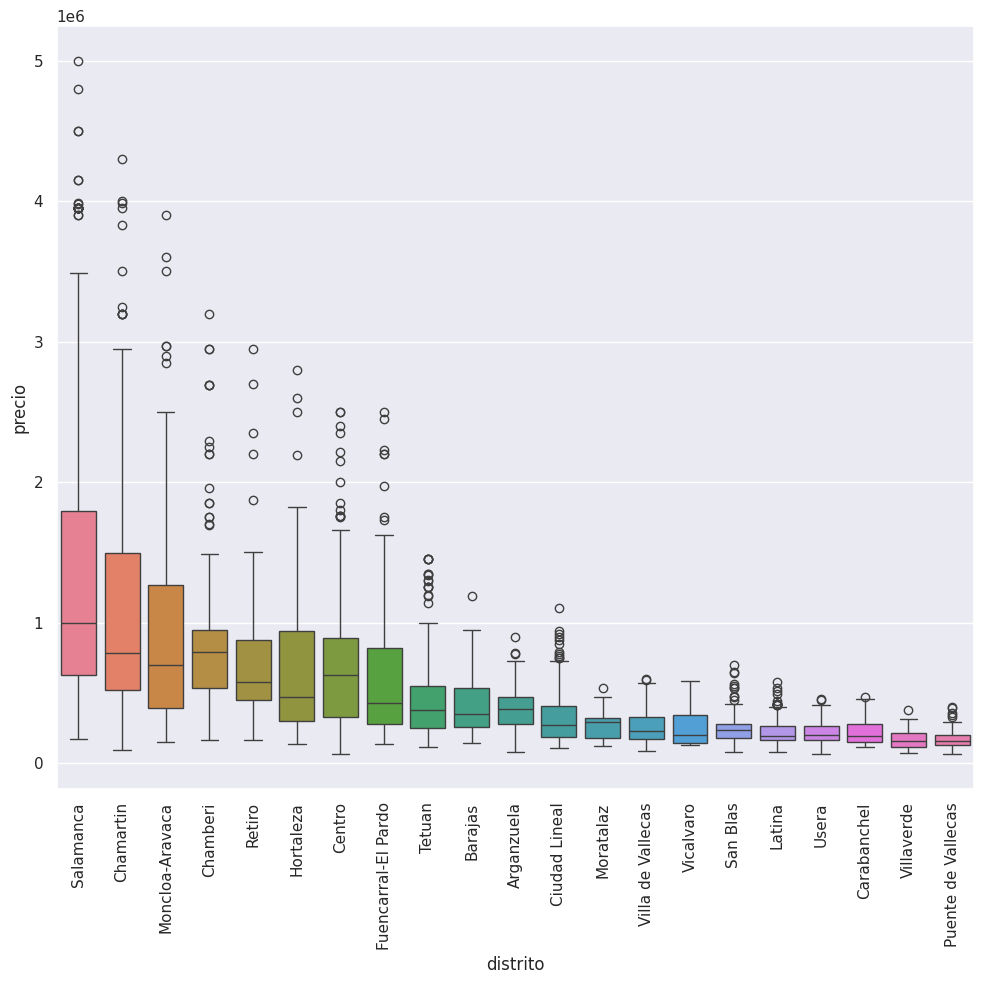

In [21]:
func_tfg.boxplot_num(datos_distrito_final, 'precio', 'distrito', 'precio')
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Valores Atipicos/Boxplot2precio.png')
plt.show()

Comenzamos realizando el boxplot para la superficie construida según el distrito al que pertenezcan.

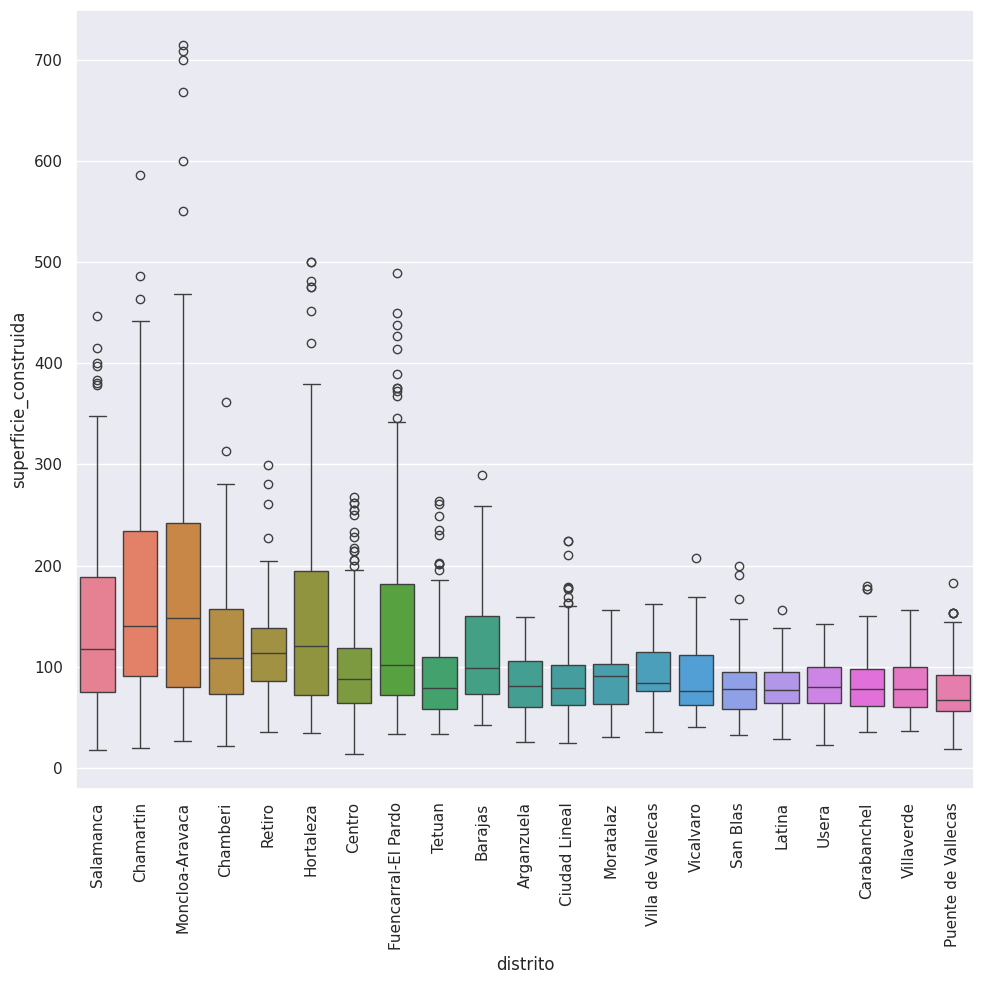

In [22]:
func_tfg.boxplot_num(datos_distrito_final, 'superficie_construida', 'distrito', 'precio')
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Valores Atipicos/Boxplot2superficie.png')
plt.show()

Comenzamos realizando el boxplot para el número de habitaciones según el distrito al que pertenezcan.

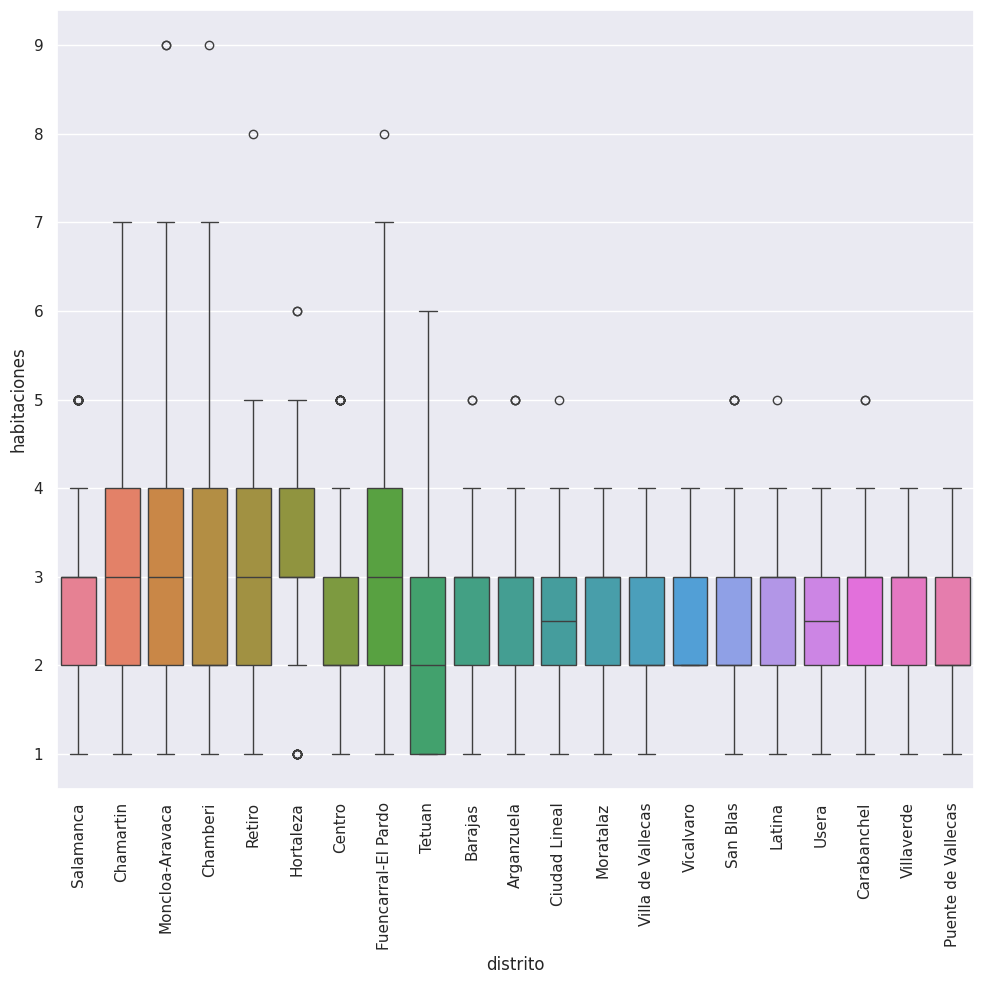

In [23]:
func_tfg.boxplot_num(datos_distrito_final, 'habitaciones', 'distrito', 'precio')
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Valores Atipicos/Boxplot2habitaciones.png')
plt.show()

Comenzamos realizando el boxplot para el número de baños según el distrito al que pertenezcan.

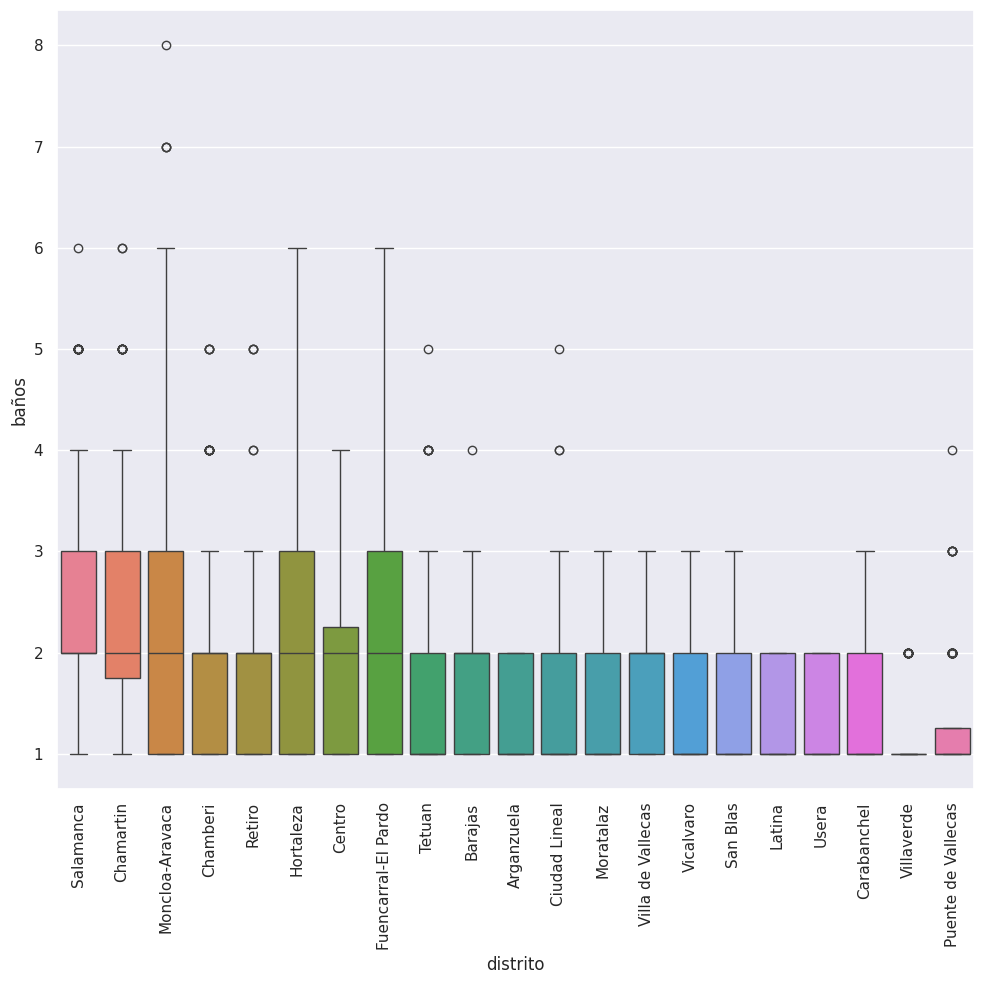

In [24]:
func_tfg.boxplot_num(datos_distrito_final, 'baños', 'distrito', 'precio')
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Valores Atipicos/Boxplot2baños.png')
plt.show()

Como vemos, ahora prácticamente no tenemos valores atípicos extremos, y los valores atípicos que observamos son muy cercanos al rango intercuartílico (IQR).



Hacemos esto para nuestro conjunto de datos real también, que es sobre el que se realizará el preprocesamiento de los datos y el que vamos a utilizar para entrenar los modelos de aprendizaje supervisado.

In [25]:
num = ['precio', 'superficie_construida', 'habitaciones']
b = datos.copy()
dim = [b.shape]
for i in num:
  datos_finales = func_tfg.valores_atipicos(b, i, 'distrito')
  b = datos_finales.copy()
  dim.append(b.shape)

Obtenemos las dimensiones de los datos a medida que se van eliminando los valores atipicos demasiado extremos.

In [26]:
tabla_dimensiones = pd.DataFrame(dim, index = ['Original', 'Precio', 'Superficie Construida', 'Habitaciones'], columns = ['Filas', 'Columnas'])
tabla_dimensiones.to_excel('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Valores Atipicos/Dimensiones.xlsx')
tabla_dimensiones.head()

,Filas,Columnas
Original,2918,14
Precio,2794,14
Superficie Construida,2779,14
Habitaciones,2761,14


Guardamos los datos finales en un archivo csv.

In [27]:
datos_finales.to_csv('/content/drive/MyDrive/TFG/Trabajo/datos_finales.csv')

### 3.2 Exploración Básica del Conjunto de Datos

Obtenemos las dimensiones del conjunto de datos.

In [28]:
dimensiones = pd.DataFrame({'Filas' : [datos_finales.shape[0]], 'Columnas': [datos_finales.shape[1]]})
dimensiones.to_excel('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Tablas/Dimensiones.xlsx')
dimensiones.head()

,Filas,Columnas
0,2761,14


Obtenemos los tipos de variables.

In [29]:
tipo_variable = pd.DataFrame(datos_finales.dtypes, columns = ['Tipo de Variable'])
tipo_variable.to_excel('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Tablas/Tipo_Variable.xlsx')
tipo_variable.head(15)

,Tipo de Variable
tipo_vivienda,object
distrito,object
precio,int64
piscina,int64
terraza,int64
jardin,int64
garaje,int64
trastero,int64
calefaccion,int64
aire_acondicionado,int64


Tenemos 2 variables numéricas continuas que son **precio** y **superficie_construida**, 2 variables numéricas enteras que son **habitaciones** y **baños**, 1 variable categórica multiclase que es el **distrito** y 8 variables categóricas binarias.

Obtenemos un resumen básico de las variables numéricas.

In [30]:
var_numericas = datos_finales.drop(var_bin.columns, axis = 1)
descripcion = var_numericas.describe()
descripcion.to_excel('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Tablas/Descripcion.xlsx')
descripcion.head(10)

,precio,superficie_construida,habitaciones,baños
count,2.761000e+03,2758.000000,2663.000000,2658.000000
mean,6.105040e+05,110.216099,2.669546,1.817532
std,6.676246e+05,74.424459,1.091460,1.016703
min,6.035300e+04,14.000000,1.000000,1.000000
25%,2.100000e+05,65.000000,2.000000,1.000000
50%,3.690000e+05,89.000000,3.000000,2.000000
75%,7.423500e+05,128.000000,3.000000,2.000000
max,5.000000e+06,714.000000,9.000000,8.000000


Vemos si hay valores faltantes en los datos.

In [31]:
faltantes = pd.DataFrame(datos_finales.isna().sum(), columns = ['Valores Faltantes'])
faltantes.to_excel('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Tablas/Faltantes.xlsx')
faltantes.head(15)

,Valores Faltantes
tipo_vivienda,0
distrito,0
precio,0
piscina,0
terraza,0
jardin,0
garaje,0
trastero,0
calefaccion,0
aire_acondicionado,0


### 3.3 Visualización y Creación de Gráficos

Obtenemos un histograma de las variables numéricas del conjunto de datos, donde podemos ver la distribución de cada variable.

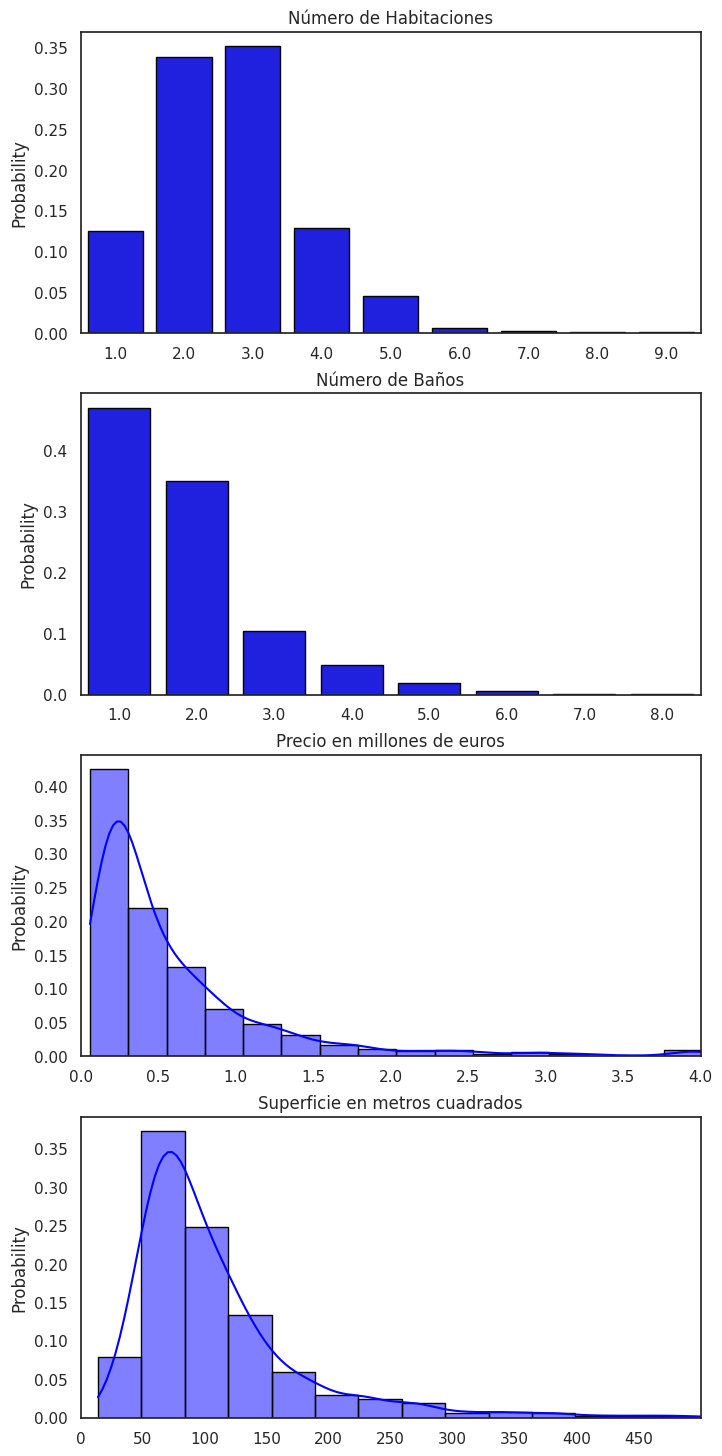

In [32]:
plt.figure(figsize = (8,18))
sns.set(style = 'white')

prob_hab = datos_finales['habitaciones'].value_counts(normalize = True).sort_index()
datos_prob_hab = pd.DataFrame({'habitaciones': prob_hab.index, 'probabilidad': prob_hab.values})

plt.subplot(4, 1, 1)
sns.barplot(data = datos_prob_hab, x = 'habitaciones', y = 'probabilidad', edgecolor = 'black', color = 'blue')
plt.title('Número de Habitaciones')
plt.ylabel('Probability')
plt.xlabel('')

prob_baños = datos_finales['baños'].value_counts(normalize = True).sort_index()
datos_prob_baños = pd.DataFrame({'baños': prob_baños.index, 'probabilidad': prob_baños.values})

plt.subplot(4, 1, 2)
sns.barplot(data = datos_prob_baños, x = 'baños', y = 'probabilidad', color = 'blue', edgecolor = 'black')
plt.title('Número de Baños')
plt.ylabel('Probability')
plt.xlabel('')

plt.subplot(4, 1, 3)
sns.histplot(datos_finales['precio']/1e6, bins = 20, edgecolor = 'black', color = 'blue', kde = True, stat = 'probability')
plt.title('Precio en millones de euros')
plt.xlabel('')
plt.xlim(0, 4)
plt.ticklabel_format(axis = 'x', style = 'plain')

plt.subplot(4, 1, 4)
sns.histplot(datos_finales['superficie_construida'], bins = 20, edgecolor = 'black', color = 'blue', kde = True, stat = 'probability')
plt.title('Superficie en metros cuadrados')
plt.xlabel('')
plt.xlim(0, 500)
plt.xticks(range(0,500,50))

plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Resto Graficos/Hist_Num.png')
plt.show()

Obtenemos un histograma de las variables categóricas multiclase del conjunto de datos, donde podemos ver la distribución de cada variable.

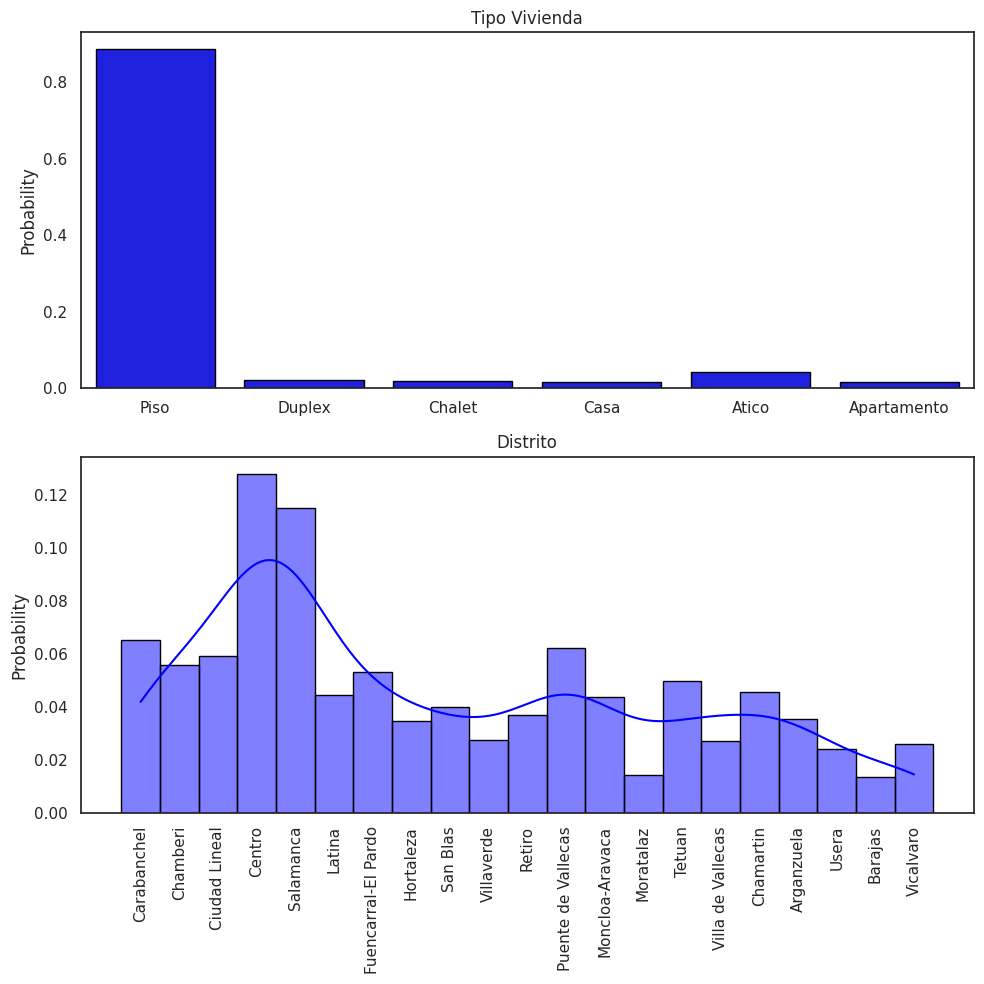

In [33]:
plt.figure(figsize = (10,10))
sns.set(style = 'white')

prob_tipo = datos_finales['tipo_vivienda'].value_counts(normalize = True).sort_index(ascending = False)
datos_prob_tipo = pd.DataFrame({'tipo_vivienda': prob_tipo.index, 'probabilidad': prob_tipo.values})

plt.subplot(2, 1, 1)
sns.barplot(data = datos_prob_tipo, x = 'tipo_vivienda', y = 'probabilidad', edgecolor = 'black', color = 'blue')
plt.title('Tipo Vivienda')
plt.ylabel('Probability')
plt.xlabel('')

plt.subplot(2, 1, 2)
sns.histplot(datos_finales['distrito'], bins = 21, edgecolor = 'black', color = 'blue', kde = True, stat = 'probability')
plt.title('Distrito')
plt.xlabel('')
plt.xticks(rotation = 90)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Resto Graficos/Hist_Cat.png')
plt.show()

Obtenemos un gráfico de barras para cada variable categórica binaria del conjunto de datos.

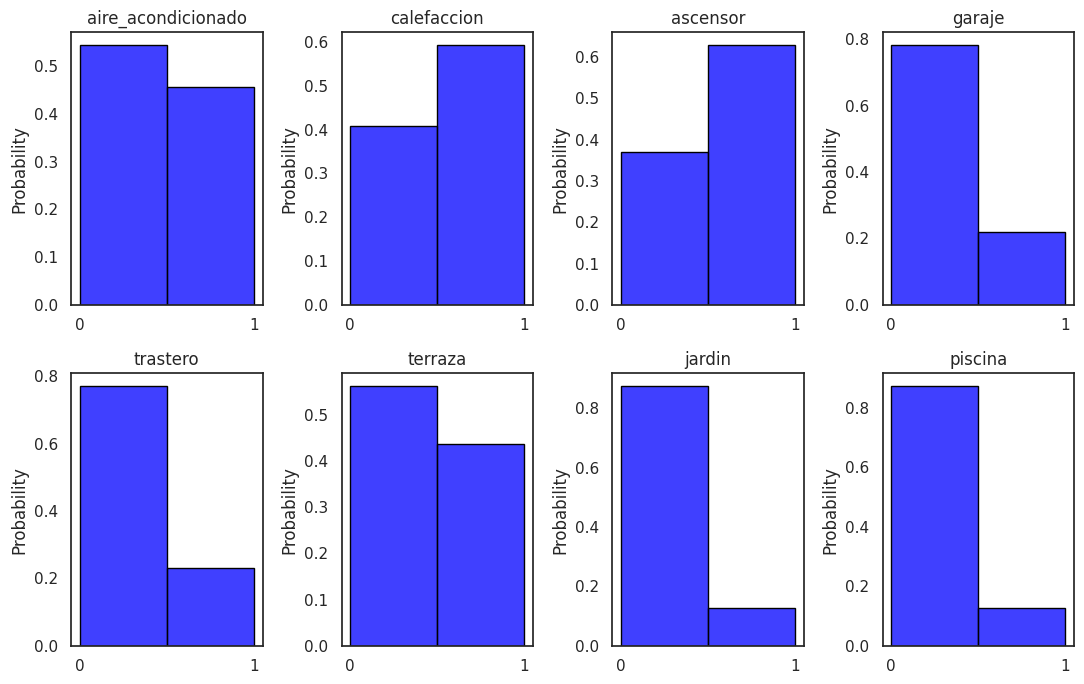

In [34]:
plt.figure(figsize = (11, 7))
datos_var_dico = datos_finales[var_bin.columns]
for i, col in enumerate(datos_var_dico):
  plt.subplot(2, 4, i+1)
  sns.histplot(datos_var_dico[col], edgecolor = 'black', color = 'blue', stat = 'probability', binwidth = 0.5)
  plt.xlabel('')
  plt.title(col)
  plt.xticks([0, 1], [0, 1])

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Resto Graficos/Hist_Bin.png')
plt.show()

Obtenemos la matriz de correlaciones de los datos incluyendo la variable **distrito**.

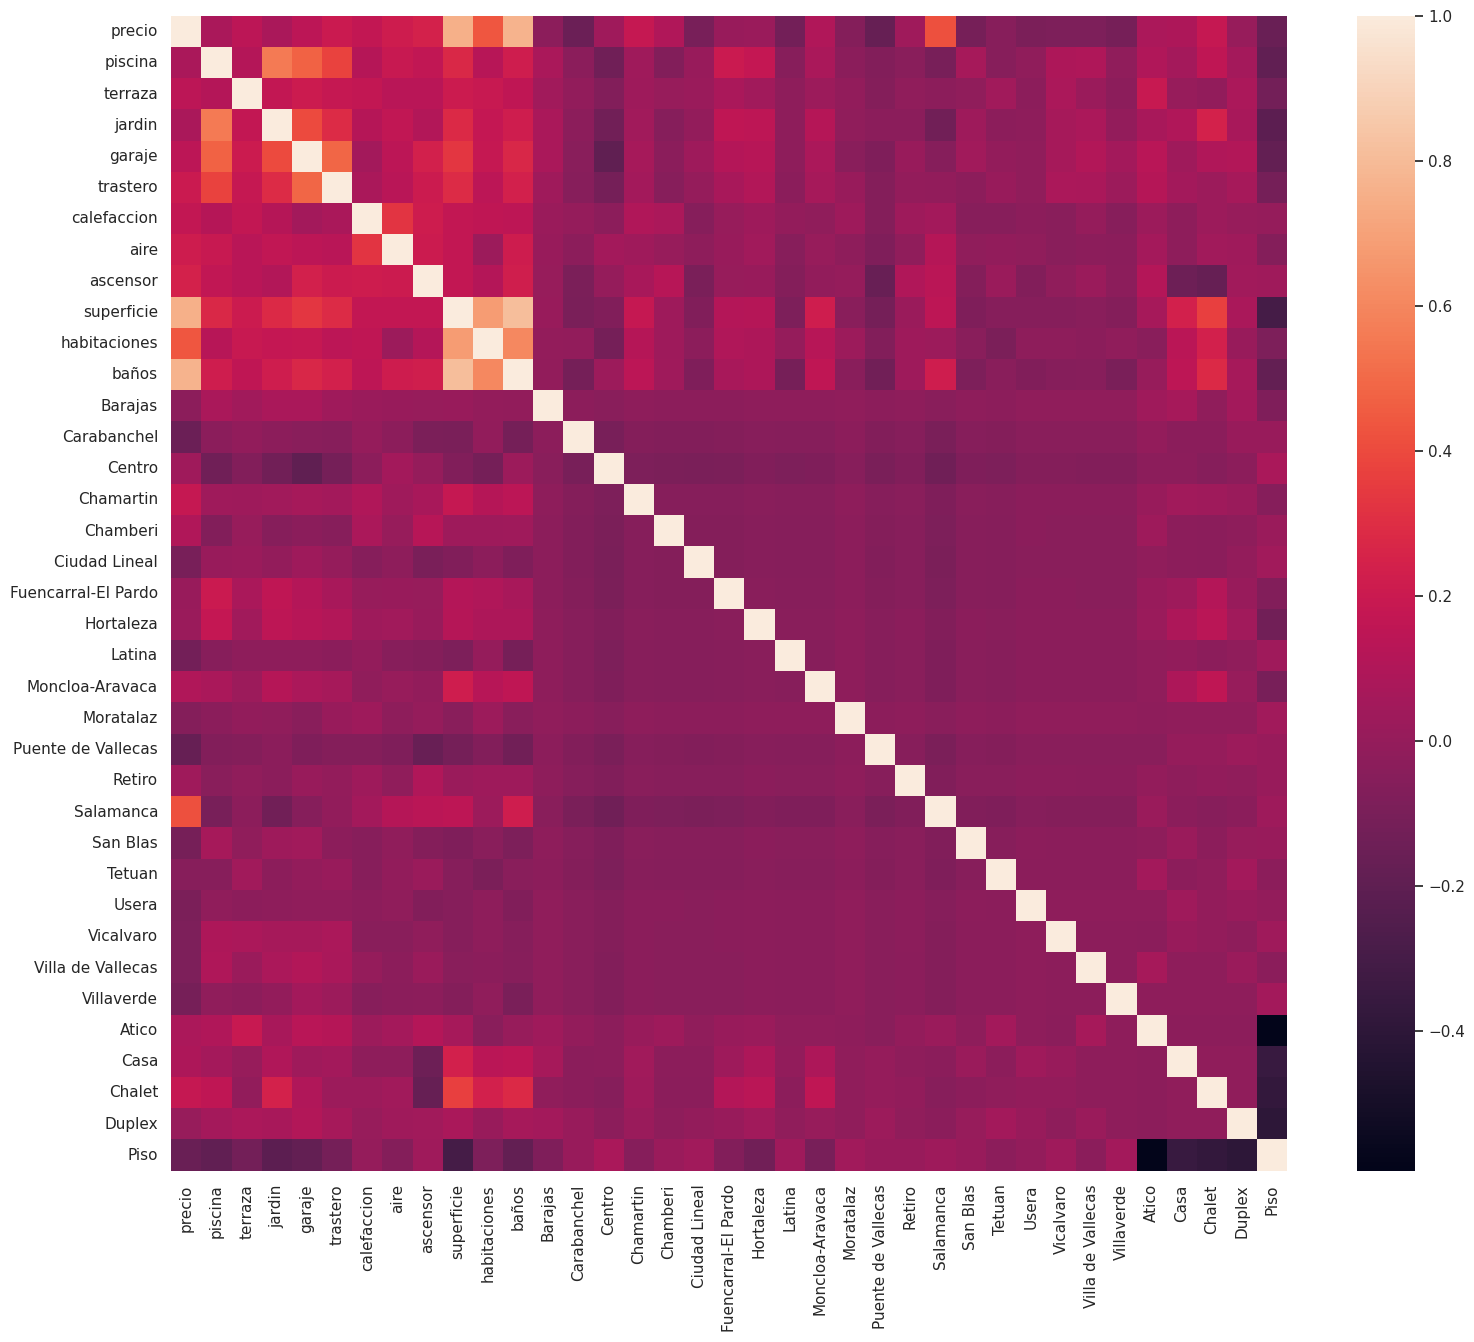

In [35]:
datos_mcorr = datos_finales.copy()
s_dist = pd.get_dummies(datos_mcorr['distrito'], drop_first = True, dtype = int)
datos_mcorr.drop(['distrito'], axis = 1, inplace = True)
s_tipo = pd.get_dummies(datos_mcorr['tipo_vivienda'], drop_first = True, dtype = int)
datos_mcorr.drop(['tipo_vivienda'], axis = 1, inplace = True)
datos_cor = pd.concat([datos_mcorr, s_dist, s_tipo], axis = 1)
datos_cor.rename(columns = {'aire_acondicionado': 'aire', 'superficie_construida': 'superficie'}, inplace = True)
mcor = datos_cor.corr(method = 'pearson')
plt.figure(figsize = (18, 15))
sns.heatmap(mcor)

plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Resto Graficos/Matriz_Correlaciones1.png')
plt.show()

Como vemos, las variables dummies están muy poco correladas con el resto de variables, luego las eliminamos para mejorar la visualización de la matriz de correlaciones.

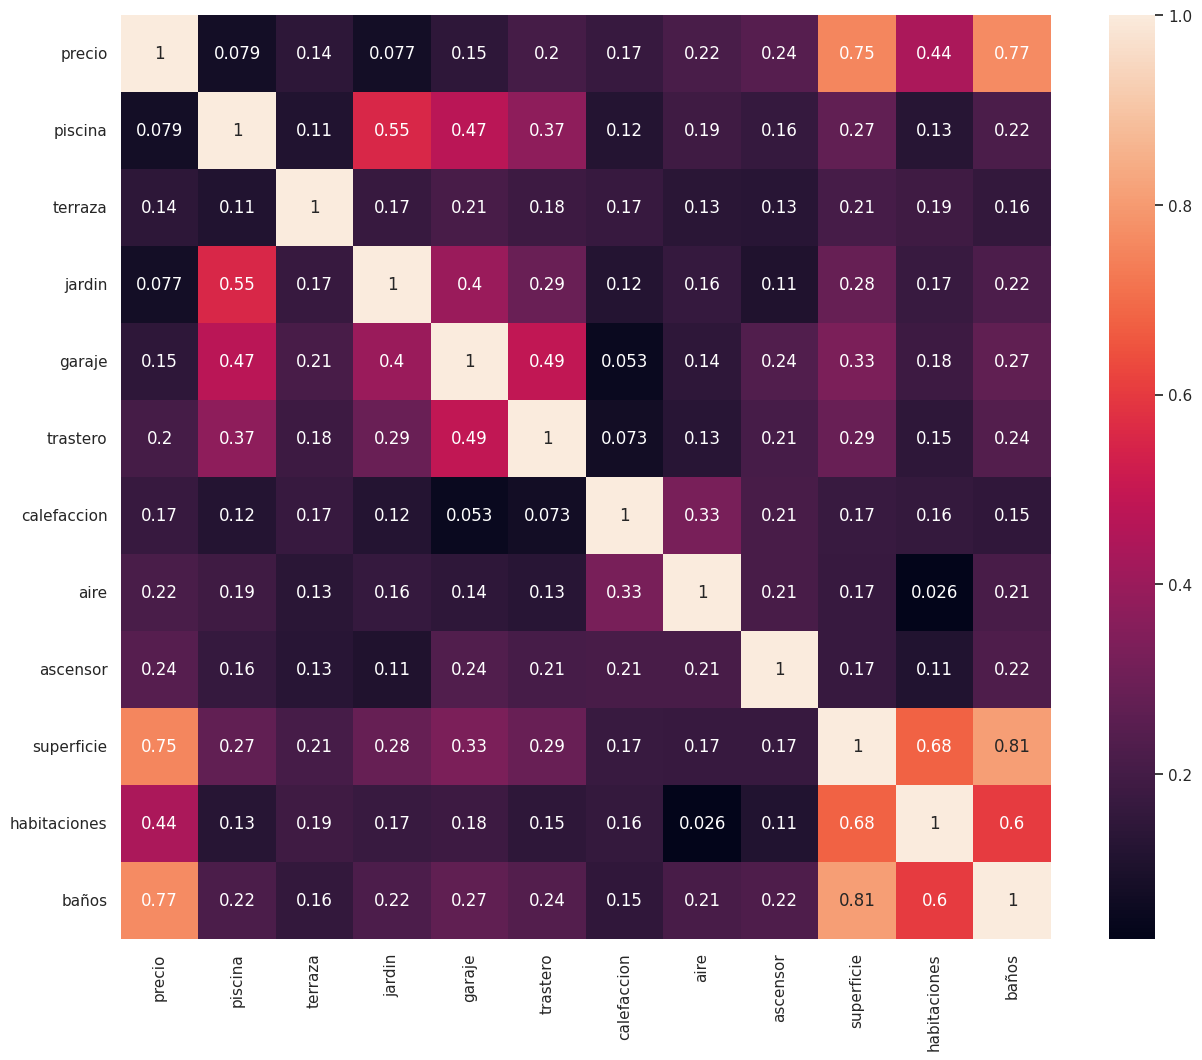

In [36]:
datos_mcorr = datos_finales.copy()
datos_mcorr.drop(['distrito', 'tipo_vivienda'], axis = 1, inplace = True)
datos_mcorr.rename(columns = {'aire_acondicionado': 'aire', 'superficie_construida': 'superficie'}, inplace = True)
mcor = datos_mcorr.corr(method = 'pearson')
plt.figure(figsize = (15, 12))
sns.heatmap(mcor, annot = True)

plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Resto Graficos/Matriz_Correlaciones2.png')
plt.show()

Gráfico de dispersión de las variables numéricas.

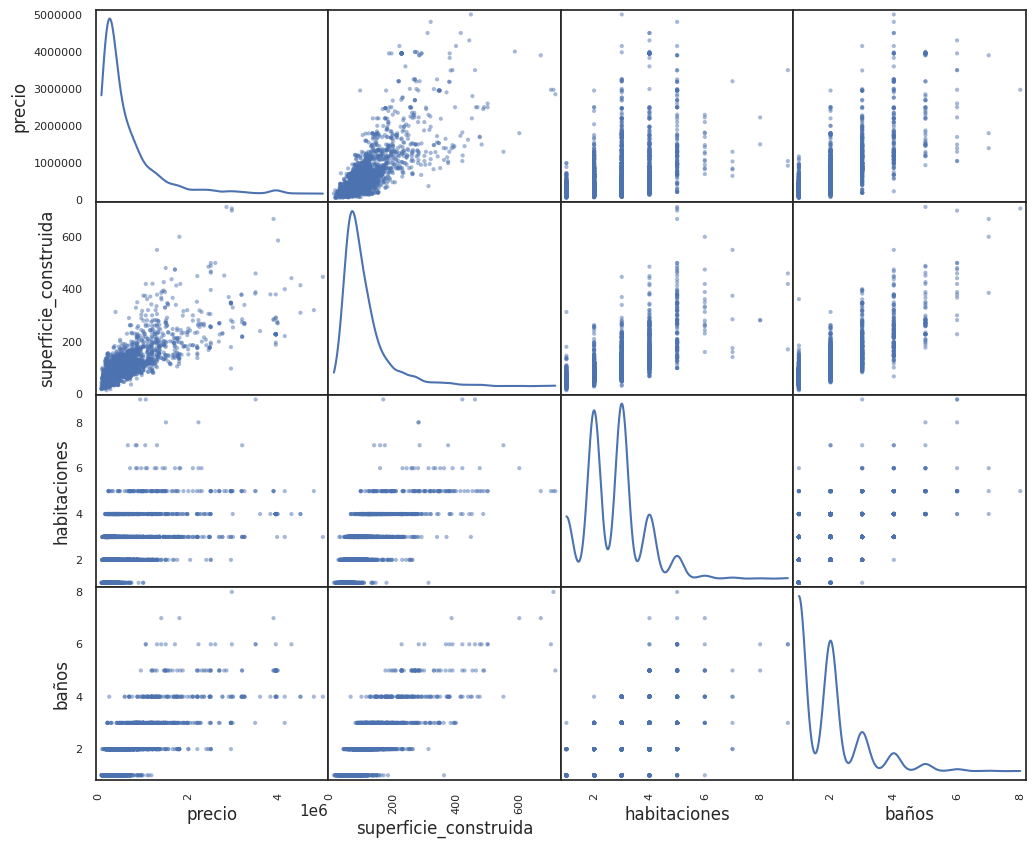

In [37]:
var_num = datos_finales[['precio', 'superficie_construida', 'habitaciones', 'baños']]
pd.plotting.scatter_matrix(var_num, figsize = (12,10), diagonal = 'kde')
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Resto Graficos/Scatterplot.png')
plt.show()

Podemos ver ahora el precio medio y mediano de las viviendas según el distrito, para ver si podemos esperar grandes diferencias entre unos y otros.

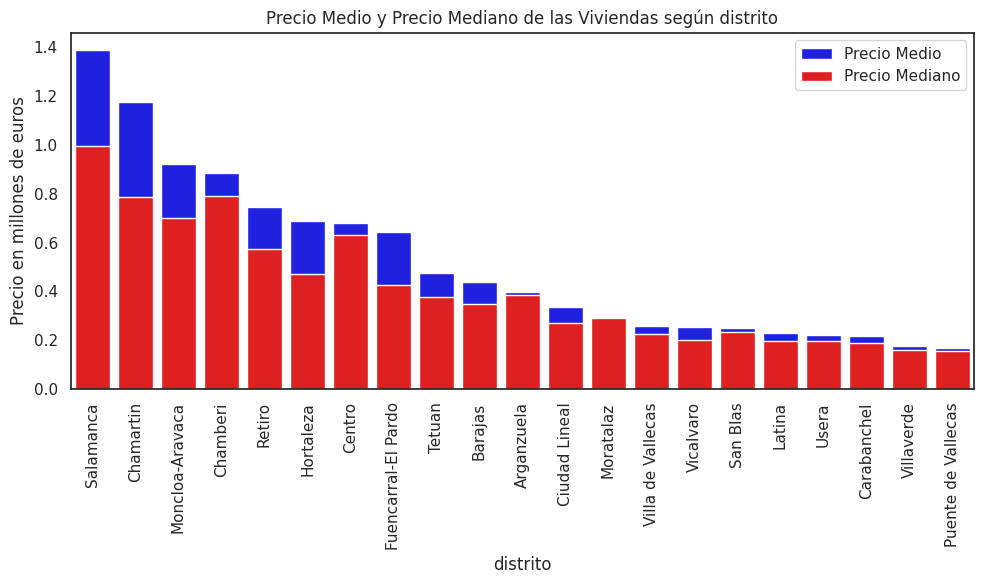

In [38]:
precio_medio_distrito = datos_finales.groupby(['distrito'])['precio'].mean()/1e6
precio_mediano_distrito = datos_finales.groupby(['distrito'])['precio'].median()/1e6
orden = datos_finales.groupby(['distrito'])['precio'].mean().sort_values(ascending = False).index

plt.figure(figsize = (10,6))
sns.barplot(x = precio_medio_distrito.index , y = precio_medio_distrito.values, order = orden, color = 'blue', label = 'Precio Medio')
sns.barplot(x = precio_mediano_distrito.index , y = precio_mediano_distrito.values, order = orden, color = 'red', label = 'Precio Mediano')
plt.xticks(rotation = 90)
plt.title('Precio Medio y Precio Mediano de las Viviendas según distrito')
plt.ylabel('Precio en millones de euros')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Resto Graficos/Precio_Medio_distrito.png')
plt.show()

Vemos si las variable numéricas se ajustan a una distribución normal.


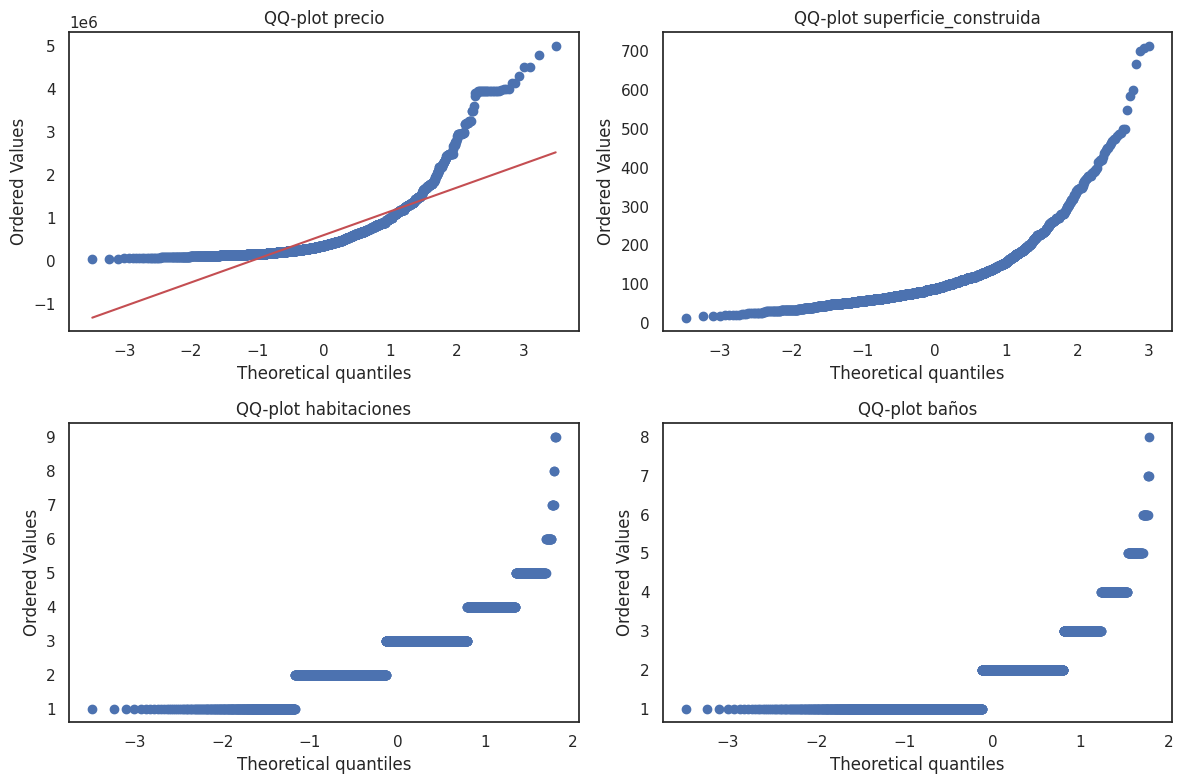

In [39]:
plt.figure(figsize = (12,8))
for i, col in enumerate(var_num):
  plt.subplot(2, 2, i+1)
  stats.probplot(datos_finales[col], dist = 'norm', plot = plt)
  plt.title(f'QQ-plot {col}')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/EDA/Resto Graficos/QQ_Plot.png')
plt.show()

## 4. Preproceso

Dividimos los datos en la variable respuesta **Y = precio** y el resto de variables **X** actuarán como predictoras.

In [40]:
X = datos_finales.drop(['precio'], axis = 1)
Y = datos_finales['precio']

Dividimos los datos en dos conjuntos: uno que se va a utilizar para el entrenamiento del modelo y otro que se va a usar para validar el modelo.

Podemos realizar esta división con el método **holdout**, donde dividimos aleatoriamente los datos en un conjunto de entrenamiento y otro de validación.
En este caso, vamos a utilizar un holdout = 3/4; es decir, 3/4 de los datos se dedican a entrenamiento del modelo y 1/4 a validación.

**Nota**: Debemos fijar una semilla aleatoria para que los resultados no varíen con la ejecución del código en distintas ocasiones.

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 1/4, random_state = 129)

Necesitamos crear un pipeline para variables numéricas, que se va a encargar del escalado de los datos realizando una estandarización y además va a imputar los valores faltantes utilizando el método KNN. Al utilizar el KNN como método para imputar los valores faltantes, se aumenta el tiempo de ejecución de las tareas pero permite obtener resultados más precisos y no se descartan los datos.

Para las variables categóricas multiclase necesitamos aplicar la codificacion binaria con OneHotEncoder y para las variables categoricas binarias no tenemos que realizar ningun tipo de preproceso pues ya las hemos codificado antes.

In [42]:
var_num = ['superficie_construida', 'habitaciones', 'baños']
var_cat = ['distrito', 'tipo_vivienda']
var_bin = ['piscina', 'terraza', 'jardin', 'garaje', 'trastero', 'calefaccion', 'aire_acondicionado', 'ascensor']

num_pipeline = Pipeline([('imputer', IterativeImputer(KNeighborsRegressor())),
                         ('scaler', StandardScaler())])
cat_pipeline = Pipeline([('onehot', OneHotEncoder())])

preproceso = ColumnTransformer([('num', num_pipeline, var_num),
                                ('cat', cat_pipeline, var_cat)],
                               remainder = 'passthrough')

## 5 Aprendizaje Supervisado

### 5.1 Ajuste de Hiperparámetros

Como métodos de aprendizaje supervisado vamos a considerar:
1. KNN
2. Árbol de Decisión
3. SVM
4. Gradient Boosting
5. Random Forest
6. Redes Neuronales (Perceptrón Multicapa)

Para todos los métodos de aprendizaje supervisado se va a utilizar tanto validación interna para el **ajuste de hiperparámetros** como validación externa para el **entrenamiento del modelo**.

Para la validación interna utilizamos **validación cruzada con k = 10 folds** y para la validación externa utilizamos el **holdout** que se ha definido con anterioridad (1/4 test y 3/4 entrenamiento).

En la validación interna, que es el ajuste de hiperparámetros, se va a considerar utilizar la búsqueda en rejilla **Grid Search** y **Random Search**.
Con el **Grid Search** se prueban todas las posibles combinaciones de valores de los hiperparámetros mientras que con el **Random Search** se prueban solamente unas pocas combinaciones de valores de forma aleatoria.

En esta fase, el objetivo es entrenar una serie de modelos de aprendizaje supervisado y determinar cuál es el que mejores resultados obtiene en términos de las métricas de evaluación que se han definido para el modelo.

Para el método **KNN (K Nearest Neighbors)**, se ajustan el **número de vecinos** y la **medida de distancia** utilizada.

In [49]:
params = {'regresor__n_neighbors': range(2,11),
          'regresor__metric': ['euclidean', 'manhattan', 'minkowski']}
metodo = KNeighborsRegressor()
KNN_grid = func_tfg.regresion_grid(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)
KNN_random = func_tfg.regresion_random(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)

Para el **Árbol de decisión**, se ajustan la **máxima profundidad del árbol** y el **número de instancias mínimas que debe haber en el nodo para subdividir el árbol**.

In [59]:
params = {'regresor__max_depth': range(2,20),
          'regresor__min_samples_split': range(10,30)}
metodo = DecisionTreeRegressor()
Arbol_grid = func_tfg.regresion_grid(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)
Arbol_random = func_tfg.regresion_random(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)

Para las **Máquinas de Vectores de Soporte con Kernel Lineal** se ajusta únicamente **el coeficiente de penalización**.

In [51]:
params =  {'regresor__C': [100000, 250000, 500000, 750000, 1000000]}
metodo = SVR(kernel = 'linear')
SVM_Lineal_grid = func_tfg.regresion_grid(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)
SVM_Lineal_random = func_tfg.regresion_random(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)

Para las **Máquinas de Vectores de Soporte con Kernel Radial** se ajustan **el coeficiente de penalización** y **el impacto de una sola instancia de entrenamiento**.

In [52]:
params = {'regresor__C': [100000, 250000, 500000, 750000, 1000000],
          'regresor__gamma': np.logspace(-2, 0, 5)}
metodo = SVR(kernel = 'rbf')
SVM_Radial_grid = func_tfg.regresion_grid(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)
SVM_Radial_random = func_tfg.regresion_random(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)

Para el **Random Forest** se ajusta el **número de modelos que se crean** y la **fracción o porcentaje de variables que se extraen para cada modelo**.

In [53]:
params = {'regresor__n_estimators': [10, 50, 100, 200],
          'regresor__max_features': [0.1, 0.25, 0.5, 0.75]}
metodo = RandomForestRegressor(random_state = 129)
Random_Forest_grid = func_tfg.regresion_grid(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)
Random_Forest_random = func_tfg.regresion_random(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)

Para el **Gradient Boosting** se ajusta el **número de modelos que se crean** y la **velocidad de aprendizaje del algoritmo**.

In [54]:
params = {'regresor__n_estimators': [10, 50, 100, 200],
          'regresor__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5]}
metodo = XGBRegressor(random_state = 129)
Gradient_Boosting_grid = func_tfg.regresion_grid(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)
Gradient_Boosting_random = func_tfg.regresion_random(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)

Para la **Red Neuronal** se ajusta el **número de capas ocultas y su tamaño**, y el **número máximo de iteraciones**.

In [55]:
params = {'regresor__hidden_layer_sizes': [(64,32), (128,64), (256,128)],
          'regresor__max_iter': [1000, 2000]}
metodo = MLPRegressor(random_state = 129)
Red_Neuronal = func_tfg.redes_neuronales(preproceso, metodo, params, X_train, Y_train, X_test, Y_test)

Una vez evaluados todos los métodos de aprendizaje supervisado considerados, se guardan los resultados en un dataframe y se muestran por pantalla.

Resultados del Aprendizaje Supervisado utilizando **Grid Search** para el ajuste de hiperparámetros.

In [60]:
# Agrupamos los resultados de los métodos de Aprendizaje Supervisado en un dataframe y los ordenamos de mayor a menor R2 de entrenamiento.
resultados_grid = pd.concat([KNN_grid, Arbol_grid, SVM_Lineal_grid, SVM_Radial_grid, Random_Forest_grid, Gradient_Boosting_grid,  Red_Neuronal])
pd.set_option('display.max_colwidth', None)
resultados_grid['Metodo AS'] = ['KNN GS', 'Árbol de Decisión GS', 'SVM Kernel Lineal GS', 'SVM Kernel Radial GS',
                                'Random Forest GS', 'Gradient Boosting GS', 'Red Neuronal GS']
resultados_grid.sort_values(by = 'R2 Train', ascending = False, inplace = True)
resultados_grid.reset_index(drop = True, inplace = True)

# Cambiamos los nombres de las columnas y redondeamos los resultados a 4 decimales.
nuevos_nombres = ['Modelo', 'Hiperparametros', 'R2 Train', 'R2 Test', 'Tiempo']
resultados_grid.rename(columns = dict(zip(resultados_grid.columns, nuevos_nombres)), inplace = True)
redondeo = ['R2 Train', 'R2 Test', 'Tiempo']
for i in redondeo:
  resultados_grid[i] = round(resultados_grid[i], 4)

# Mostramos los resultados y los guardamos en un archivo excel.
resultados_grid.to_excel('/content/drive/MyDrive/TFG/Trabajo/Gráficos/Imputación KNN/Resultados_GridSearch_Imputacion.xlsx')
resultados_grid

,Modelo,Hiperparametros,R2 Train,R2 Test,Tiempo
0,SVM Kernel Radial GS,"{'regresor__C': 1000000, 'regresor__gamma': 0.1}",0.8416,0.8666,173.1699
1,Random Forest GS,"{'regresor__max_features': 0.25, 'regresor__n_estimators': 200}",0.8369,0.8734,92.2112
2,Gradient Boosting GS,"{'regresor__learning_rate': 0.1, 'regresor__n_estimators': 50}",0.8249,0.8585,40.0165
3,Red Neuronal GS,"{'regresor__max_iter': 2000, 'regresor__hidden_layer_sizes': (256, 128)}",0.8221,0.8484,1487.5157
4,KNN GS,"{'regresor__metric': 'manhattan', 'regresor__n_neighbors': 4}",0.8091,0.8156,29.0573
5,Árbol de Decisión GS,"{'regresor__max_depth': 19, 'regresor__min_samples_split': 27}",0.7904,0.8064,329.1339
6,SVM Kernel Lineal GS,{'regresor__C': 1000000},0.7169,0.7463,63.7873


Resultados del Aprendizaje Supervisado utilizando **Random Search** para el ajuste de hiperparámetros.

In [61]:
# Agrupamos los resultados de los métodos de Aprendizaje Supervisado en un dataframe y los ordenamos de mayor a menor R2 de entrenamiento.
resultados_random = pd.concat([KNN_random, Arbol_random, SVM_Lineal_random, SVM_Radial_random, Random_Forest_random, Gradient_Boosting_random, Red_Neuronal])
pd.set_option('display.max_colwidth', None)
resultados_random['Metodo AS'] = ['KNN RS', 'Árbol de Decisión RS', 'SVM Kernel Lineal RS', 'SVM Kernel Radial RS',
                                  'Random Forest RS', 'Gradient Boosting RS', 'Red Neuronal RS']
resultados_random.sort_values(by = 'R2 Train', ascending = False, inplace = True)
resultados_random.reset_index(drop = True, inplace = True)

# Cambiamos los nombres de las columnas y redondeamos los resultados a 4 decimales.
nuevos_nombres = ['Modelo', 'Hiperparametros', 'R2 Train', 'R2 Test', 'Tiempo']
resultados_random.rename(columns = dict(zip(resultados_random.columns, nuevos_nombres)), inplace = True)
redondeo = ['R2 Train', 'R2 Test', 'Tiempo']
for i in redondeo:
  resultados_random[i] = round(resultados_random[i], 4)

# Mostramos los resultados y los guardamos en un archivo excel.
resultados_random.to_excel('/content/drive/MyDrive/TFG/Trabajo/Gráficos/Imputación KNN/Resultados_RandomSearch_Imputacion.xlsx')
resultados_random

,Modelo,Hiperparametros,R2 Train,R2 Test,Tiempo
0,Random Forest RS,"{'regresor__n_estimators': 50, 'regresor__max_features': 0.5}",0.8360,0.8686,43.6334
1,Red Neuronal RS,"{'regresor__max_iter': 2000, 'regresor__hidden_layer_sizes': (256, 128)}",0.8221,0.8484,1487.5157
2,Gradient Boosting RS,"{'regresor__n_estimators': 10, 'regresor__learning_rate': 0.3}",0.8155,0.8468,25.1317
3,KNN RS,"{'regresor__n_neighbors': 4, 'regresor__metric': 'manhattan'}",0.8091,0.8156,10.8374
4,SVM Kernel Radial RS,"{'regresor__gamma': 0.03162277660168379, 'regresor__C': 500000}",0.8077,0.8400,52.7528
5,Árbol de Decisión RS,"{'regresor__min_samples_split': 21, 'regresor__max_depth': 15}",0.7875,0.8178,9.2599
6,SVM Kernel Lineal RS,{'regresor__C': 1000000},0.7169,0.7463,64.1832


Graficamos los resultados obtenidos de las métricas de evaluación de los modelos para los datos de entrenamiento y de test.

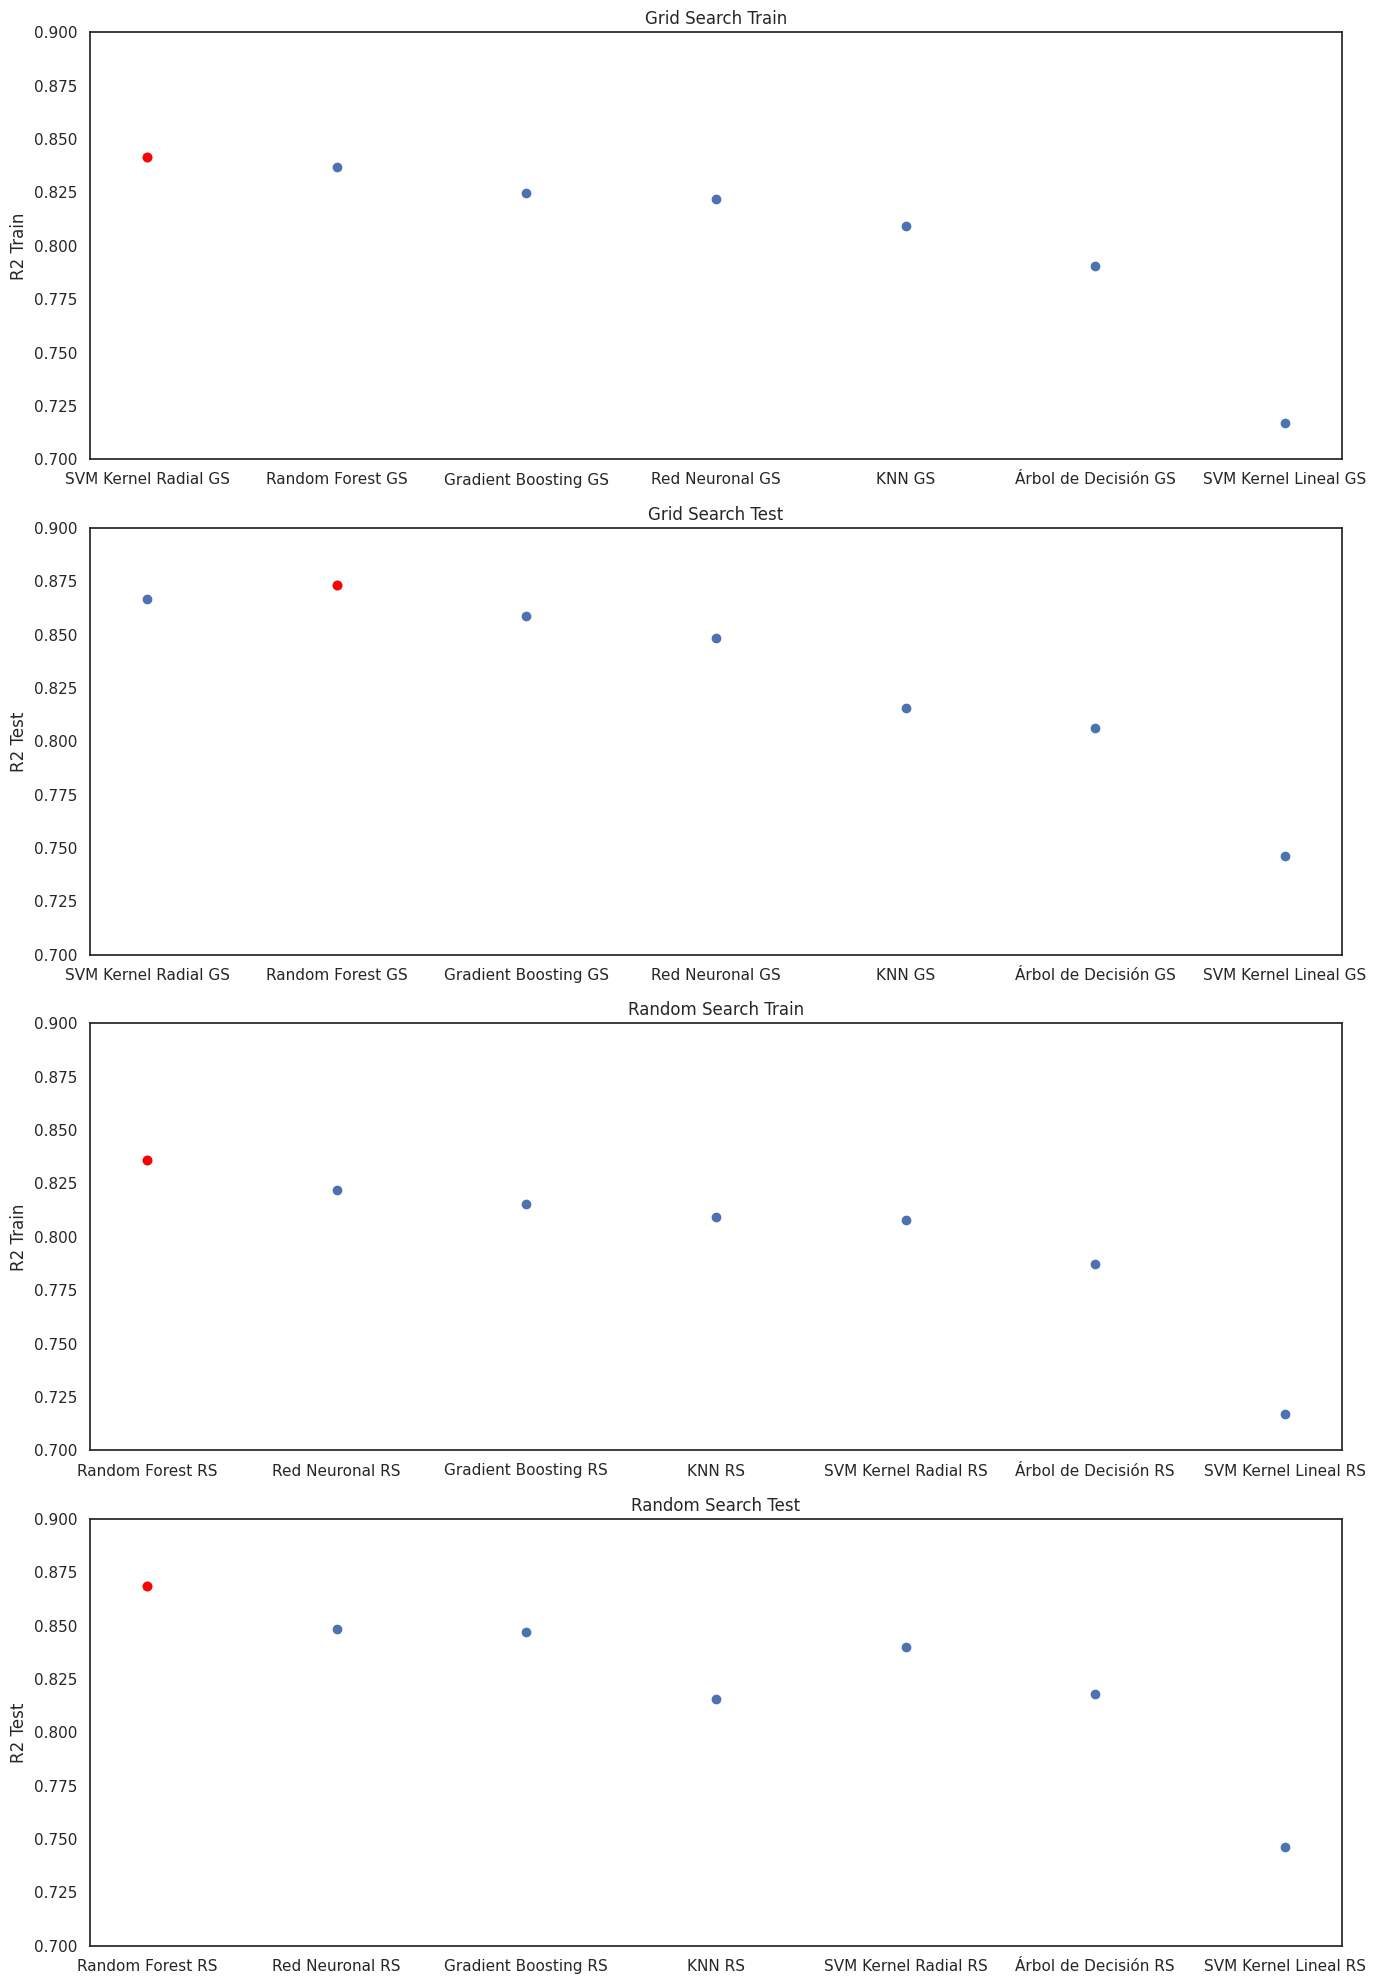

In [62]:
plt.figure(figsize = (14, 20))

plt.subplot(4, 1, 1)
x = resultados_grid['Modelo']
y = resultados_grid['R2 Train']
plt.scatter(x = x, y = y)
plt.plot(x[y.idxmax()], y[y.idxmax()], marker = 'o', color = 'red')
plt.ylim((0.70, 0.90))
plt.ylabel("R2 Train")
plt.title("Grid Search Train")

plt.subplot(4, 1, 2)
x = resultados_grid['Modelo']
y = resultados_grid['R2 Test']
plt.scatter(x = x, y = y)
plt.plot(x[y.idxmax()], y[y.idxmax()], marker = 'o', color = 'red')
plt.ylim((0.70, 0.90))
plt.ylabel("R2 Test")
plt.title("Grid Search Test")

plt.subplot(4, 1, 3)
x = resultados_random['Modelo']
y = resultados_random['R2 Train']
plt.scatter(x = x, y = y)
plt.plot(x[y.idxmax()], y[y.idxmax()], marker = 'o', color = 'red')
plt.ylim((0.70, 0.90))
plt.ylabel("R2 Train")
plt.title("Random Search Train")

plt.subplot(4, 1, 4)
x = resultados_random['Modelo']
y = resultados_random['R2 Test']
plt.scatter(x = x, y = y)
plt.plot(x[y.idxmax()], y[y.idxmax()], marker = 'o', color = 'red')
plt.ylim((0.70, 0.90))
plt.ylabel("R2 Test")
plt.title("Random Search Test")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TFG/Trabajo/Gráficos/Imputación KNN/R2_GridSearch_RandomSearch_Imputacion.png')
plt.show()

### 5.2 Preproceso Modelos Finales

Vamos a aplicar el preproceso a los datos de entrenamiento y de test para poder aplicar los modelos finales de aprendizaje supervisado.

Debemos obtener los nombres de las nuevas variables que se han creado tras aplicar la codificación binaria a la variable categórica **distrito**.

In [65]:
X_train_preproceso = pd.DataFrame(preproceso.fit_transform(X_train))
X_test_preproceso = preproceso.transform(X_test)

columnas_cat = preproceso.named_transformers_['cat']['onehot'].get_feature_names_out(var_cat)
col_cat1 = [i.replace('distrito_','') for i in columnas_cat[:21]]
col_cat2 = [i.replace('tipo_vivienda_','') for i in columnas_cat[21:27]]
col_nuevas = var_num + var_bin + list(col_cat1) + list(col_cat2)

X_train_preproceso.columns = col_nuevas
X_train_preproceso.head()

,superficie_construida,habitaciones,baños,piscina,terraza,jardin,garaje,trastero,calefaccion,aire_acondicionado,...,Usera,Vicalvaro,Villa de Vallecas,Villaverde,Apartamento,Atico,Casa,Chalet,Duplex,Piso
0,-0.926348,-1.526825,-0.794319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.031137,0.305578,1.197734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,0.597536,0.305578,0.201707,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-0.184634,-0.610624,-0.794319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
4,-0.198120,0.305578,-0.794319,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 5.3 Modelo Árbol de Decisión

Aunque no es el mejor modelo, el árbol de decisión nos permite obtener una visualización gráfica de la estructura y de las decisiones que se toman en cada nodo del árbol, así como cuáles son las variables que considera más importantes.

Ajustamos un árbol de decisión con los mejores valores de los hiperparámetros según el Random Search, que son una profundidad del árbol de 15 y con al menos 21 instancias en cada nodo para seguir subdividiendo.

In [66]:
modelo = DecisionTreeRegressor(max_depth = 15, min_samples_split = 21)
modelo.fit(X_train_preproceso, Y_train)

DecisionTreeRegressor(max_depth=15, min_samples_split=21)

Graficamos el árbol entrenado.

In [67]:
dot_data = export_graphviz(modelo, out_file = None, feature_names = X_train_preproceso.columns)
grafico_arbol = graphviz.Source(dot_data)
grafico_arbol.render("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Modelos Finales/arbol_decision")

'/content/drive/MyDrive/TFG/Trabajo/Gráficos/Modelos Finales/arbol_decision.pdf'

### 5.4 Modelo Random Forest

Vamos a utilizar el resultado que ofrece el Random Search pues en el mundo real no disponemos de recursos ilimitados.

El modelo con el que se obtiene un mejor valor de la métrica de evaluación R2 es el Random Forest con 50 árboles y 50% de características usadas en cada modelo.

In [ ]:
modelo = RandomForestRegressor(n_estimators = 50, max_features = 0.50, random_state = 129)
modelo.fit(X_train_preproceso, Y_train)

RandomForestRegressor(max_features=0.5, n_estimators=50, random_state=129)

Obtenemos las predicciones y la métrica de evaluación del modelo.

In [ ]:
pred = modelo.predict(X_test_preproceso)
r2 = r2_score(Y_test, pred)
print(f"Con el Random Forest se obtiene un R2 = {r2}")

Con el Random Forest se obtiene un R2 = 0.8686444305477918


Podemos mostrar las predicciones frente a los verdaderos valores de la variable respuesta en una tabla.

In [ ]:
pred_formato = ['{:,.0f}'.format(i).replace(',','.') for i in pred]
tabla_pred_real = pd.DataFrame({'Precio Predicción': pred_formato, 'Precio Real': Y_test})
predicciones = pd.concat([tabla_pred_real, X_test], axis = 1)
predicciones.to_excel('/content/drive/MyDrive/TFG/Trabajo/Gráficos/Modelos Finales/Predicciones.xlsx')
predicciones.head()

,Precio Predicción,Precio Real,tipo_vivienda,distrito,piscina,terraza,jardin,garaje,trastero,calefaccion,aire_acondicionado,ascensor,superficie_construida,habitaciones,baños
1462,437.153,469900,Piso,Fuencarral-El Pardo,0,0,0,0,0,1,1,1,98.0,3.0,2.0
600,1.208.449,1275000,Piso,Hortaleza,1,1,1,1,1,1,1,1,208.0,4.0,3.0
1813,488.980,548000,Piso,Centro,0,0,0,0,0,1,1,0,75.0,2.0,1.0
129,829.624,695000,Piso,Salamanca,0,0,0,0,0,1,1,1,79.0,2.0,2.0
765,681.100,648000,Piso,Centro,0,1,0,0,0,0,1,1,81.0,2.0,2.0


Obtenemos la importancia de las variables.

In [ ]:
importancia = modelo.feature_importances_
df_importancia = pd.DataFrame(importancia, index = X_train_preproceso.columns, columns = ['Importancia'])
df_importancia.sort_values(by = 'Importancia', ascending = False, inplace = True)
df_importancia.to_excel("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Modelos Finales/importancia.xlsx")
df_importancia.head(40)

,Importancia
superficie_construida,0.478326
baños,0.244580
Ciudad Lineal,0.091212
habitaciones,0.041613
Piso,0.013830
Atico,0.010549
trastero,0.010444
calefaccion,0.010436
garaje,0.010132
Duplex,0.009694


## 6. APRENDIZAJE NO SUPERVISADO

Vamos a ver si podemos agrupar las viviendas de nuestro conjunto de datos de una forma diferente, pues tenemos demasiados distritos.

Para ello, vamos a considerar los métodos de clustering para agrupar las viviendas por clústeres que sean lo mas homogeneo posible dentro de cada grupo y lo mas heterogeneo posible entre los grupos.


En el modelo de clustering utilizamos la distancia euclidea, y el criterio de Ward que minimiza la varianza dentro de cada grupo.

In [ ]:
X_preproceso = pd.DataFrame(preproceso.fit_transform(X), columns = col_nuevas)
modelo_cluster = AgglomerativeClustering(n_clusters = None, affinity = 'euclidean', linkage = 'ward', distance_threshold = 0)
modelo_cluster.fit(X_preproceso)

AgglomerativeClustering(affinity='euclidean', distance_threshold=0,
                        n_clusters=None)

Realizamos un dendrograma para el modelo cluster que acabamos de definir.

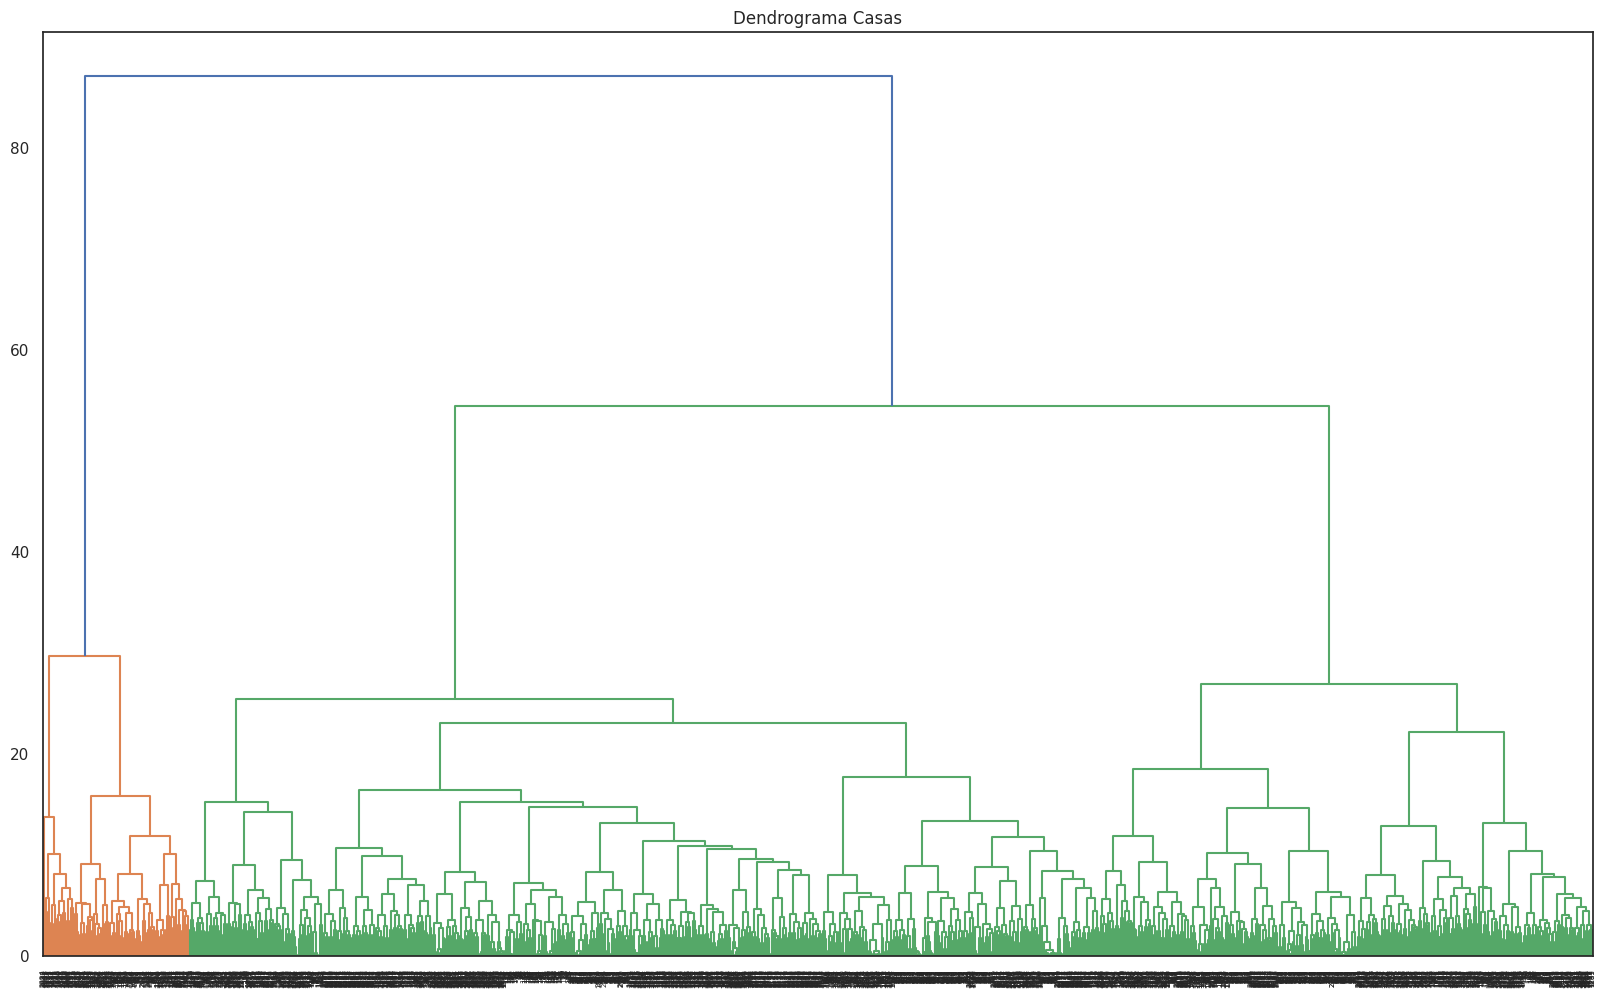

In [ ]:
func_tfg.dendrograma(modelo_cluster, truncate_mode = 'level')
plt.title("Dendrograma Casas")
plt.savefig("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Clustering/Graficos/Dendrograma.png")
plt.show()

Marcamos el punto de corte para el dendrograma.

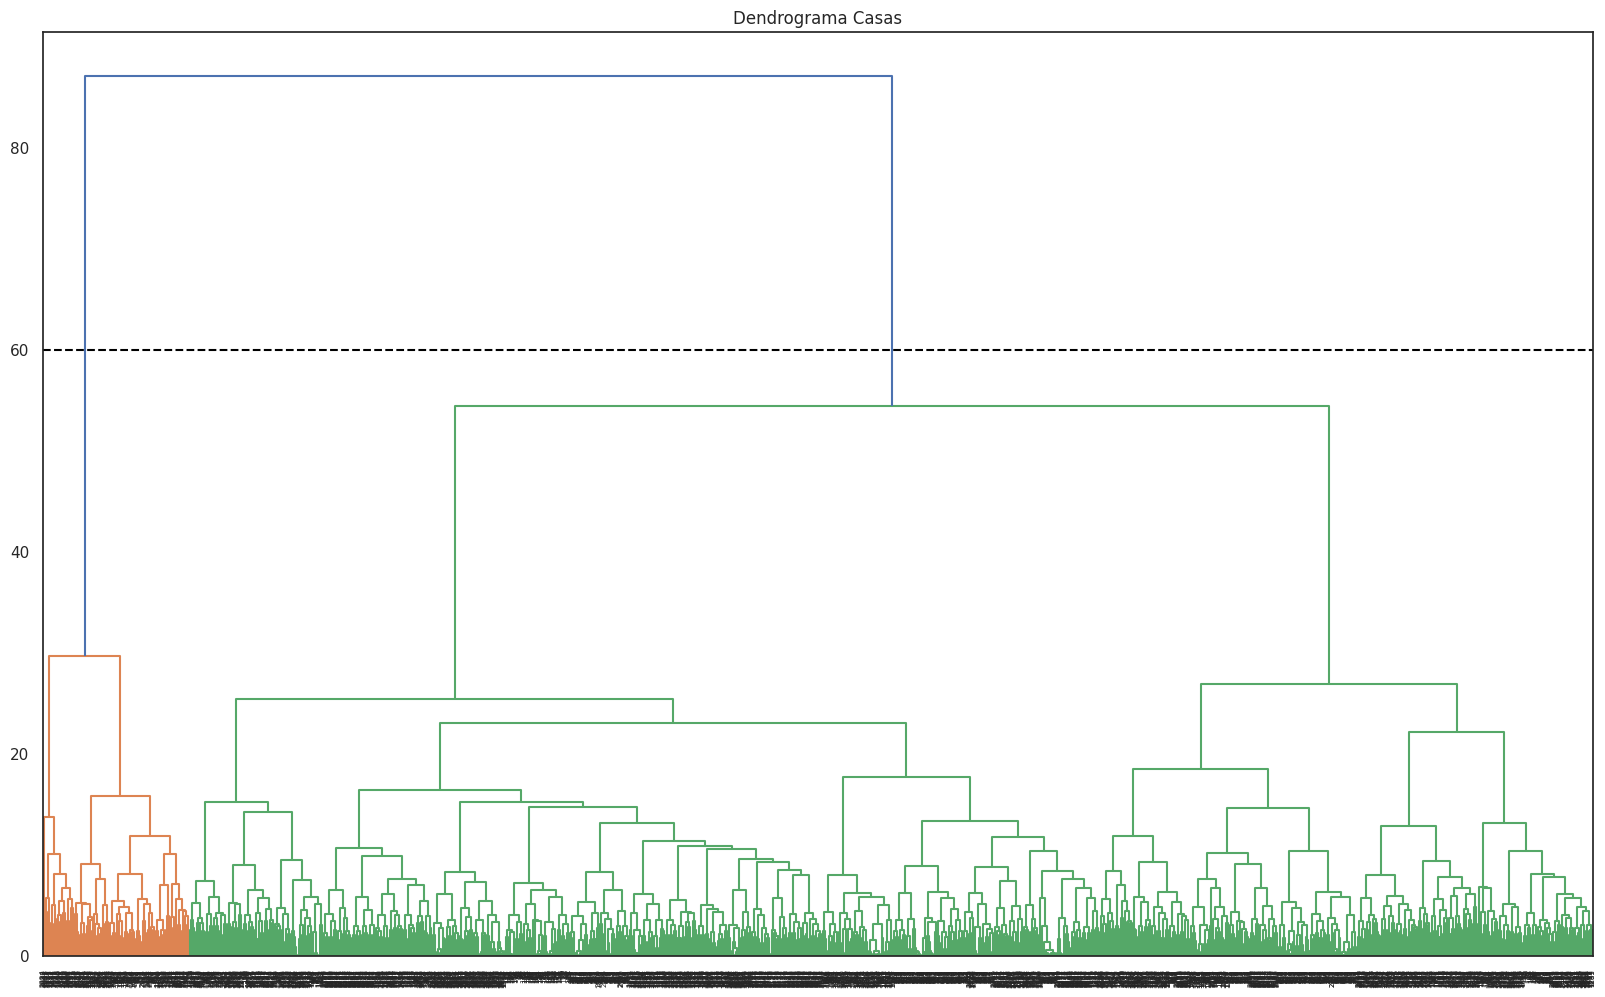

In [ ]:
func_tfg.dendrograma(modelo_cluster, color_threshold = 60)
plt.title("Dendrograma Casas")
plt.axhline(y = 60, c = 'black', linestyle = '--')
plt.savefig("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Clustering/Graficos/Dendrograma_Corte.png")
plt.show()

Ahora, buscamos obtener el numero de grupos k optimo de forma que se maximice el valor del coeficiente de la silueta media.

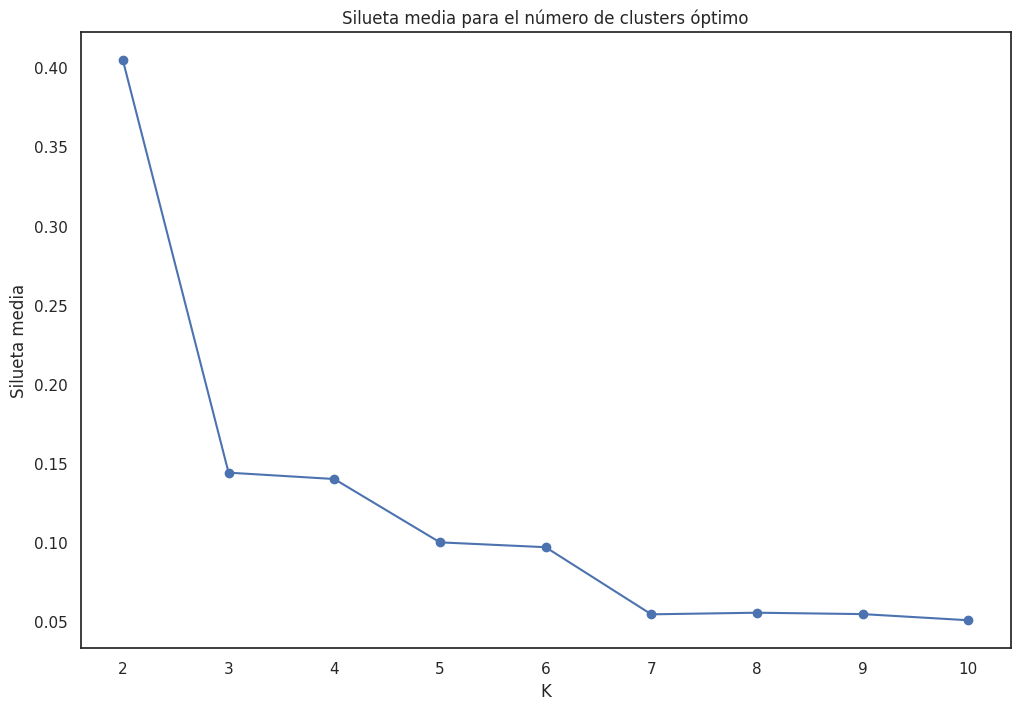

In [ ]:
silueta_media = []
rango = range(2,11)
for k in rango:
  cluster = AgglomerativeClustering(affinity = 'euclidean', linkage = 'ward', n_clusters = k)
  labels = cluster.fit_predict(X_preproceso)
  s_media = silhouette_score(X_preproceso, labels)
  silueta_media.append(s_media)

plt.figure(figsize = (12, 8))
plt.plot(rango, silueta_media, marker = 'o')
plt.xlabel("K")
plt.ylabel("Silueta media")
plt.title("Silueta media para el número de clusters óptimo")
plt.savefig("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Clustering/Graficos/Silueta_Media.png")
plt.show()

Como vemos, el valor k donde se maximiza la silueta media es k = 2, luego el modelo de clustering divide los datos en 2 grupos.

Para ver como se dividen los datos creamos un modelo de kmedias con 2 grupos o clusters.

In [ ]:
kmedias = KMeans(init = "random", random_state = 129, n_clusters = 2)
kmedias.fit(X_preproceso)
clusters = kmedias.predict(X_preproceso)

Vemos cuantas instancias pertenecen a cada grupo.

In [ ]:
datos_cluster = datos_finales.copy()
datos_cluster['ID'] = kmedias.labels_
id = datos_cluster['ID']
id.value_counts()

ID
1    2041
0     720
Name: count, dtype: int64

Una vez creado el modelo, representamos las caracteristicas numéricas de los grupos que ha determinado el metodo kmedias.


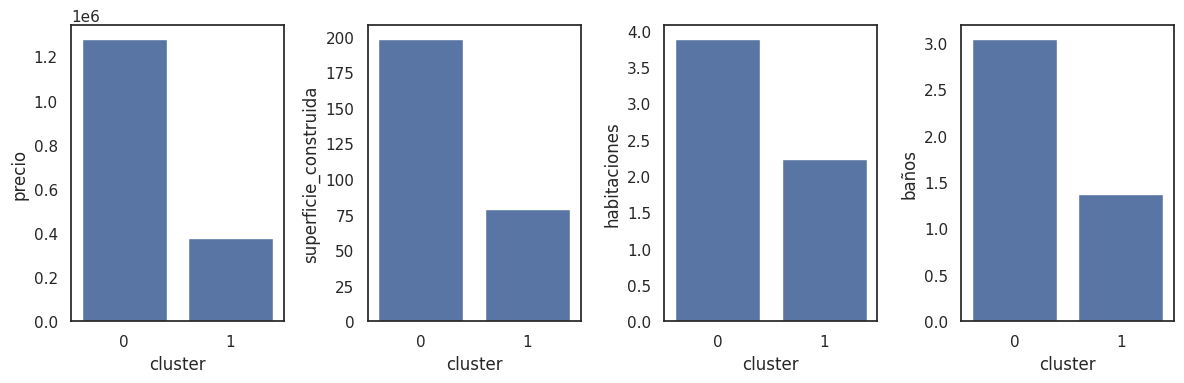

In [ ]:
datos_cluster['cluster'] = clusters
var_num = ['precio', 'superficie_construida', 'habitaciones', 'baños']
plt.figure(figsize = (12, 4))
suma = 0
for i in var_num:
  suma += 1
  plt.subplot(1, 4, suma)
  X_car = datos_cluster.groupby('cluster')[i].mean()
  sns.barplot(X_car)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Clustering/Graficos/Variables_Numericas_Cluster.png")
plt.show()

Ahora representamos las características binarias del conjunto de datos para cada grupo o cluster que se ha obtenido.

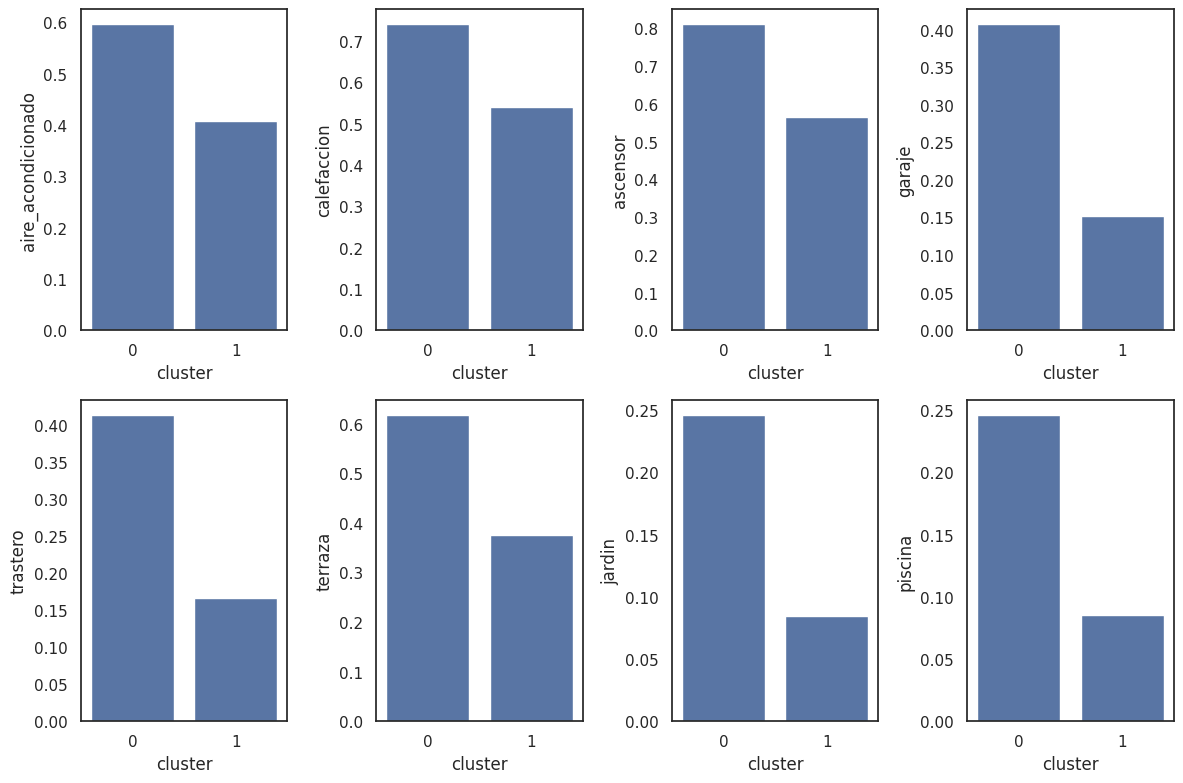

In [ ]:
datos_cluster['cluster'] = clusters
var_bin = ['aire_acondicionado', 'calefaccion', 'ascensor', 'garaje', 'trastero', 'terraza', 'jardin', 'piscina']
plt.figure(figsize = (12, 8))
suma = 0
for i in var_bin:
  suma += 1
  plt.subplot(2, 4, suma)
  X_car = datos_cluster.groupby('cluster')[i].mean()
  sns.barplot(X_car)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Clustering/Graficos/Variables_Binarias_Cluster.png")
plt.show()

Vemos las características de cada clúster para la variable categórica multiclase **tipo de vivienda**.

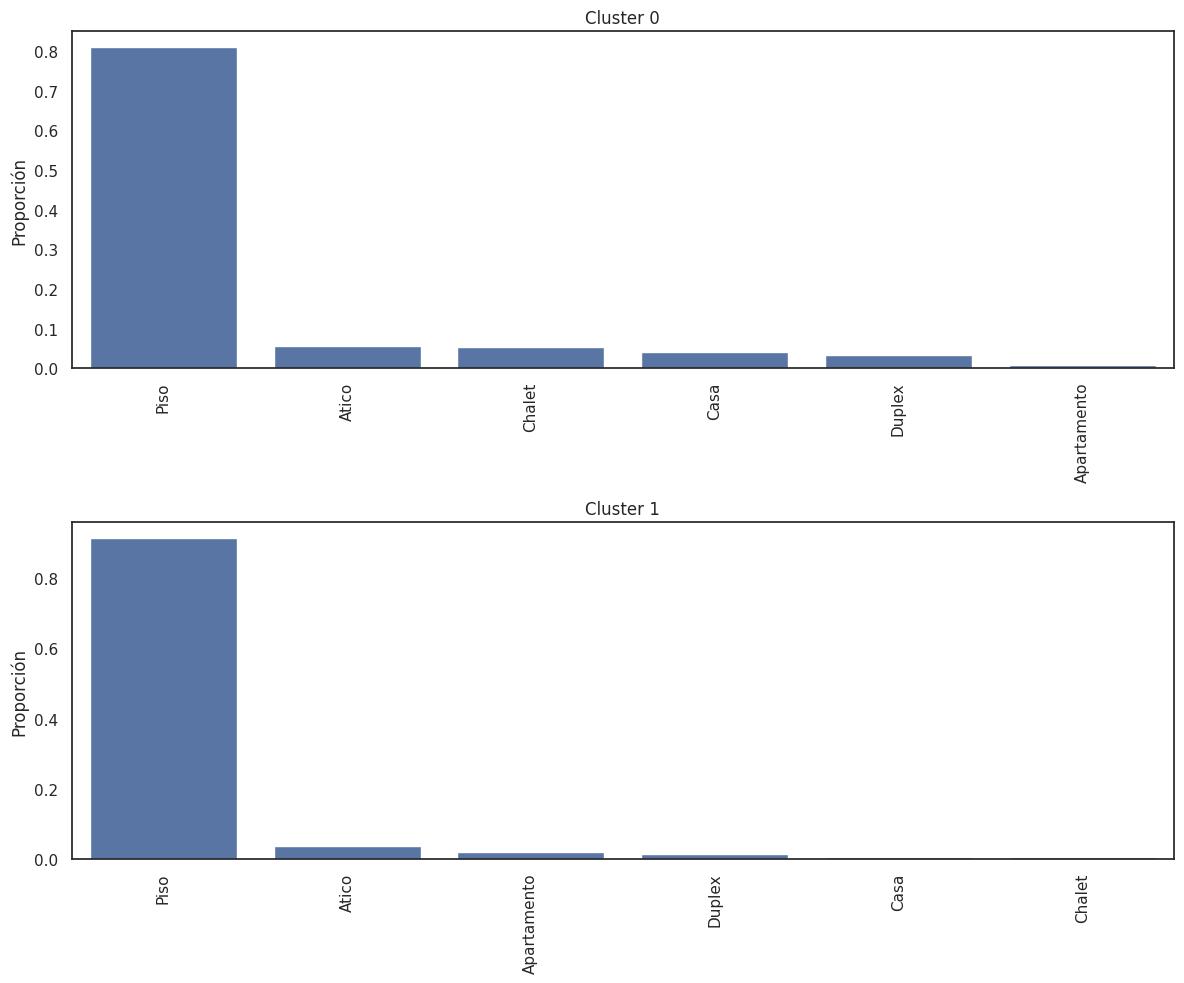

In [ ]:
plt.figure(figsize = (12, 10))
suma = 3
n_cluster = datos_cluster['ID'].unique()
for i in n_cluster:
    suma -= 1
    plt.subplot(2, 1, suma)
    datos_cluster_i = datos_cluster[datos_cluster['ID'] == i]
    cluster_i = datos_cluster_i.groupby(['cluster', 'tipo_vivienda']).size().reset_index(name = 'tamaño')
    cluster_i['proporcion'] = cluster_i['tamaño']/sum(cluster_i['tamaño'])
    cluster_i.sort_values(by = 'proporcion', ascending = False, inplace = True)
    etiquetas_distrito = cluster_i['tipo_vivienda'].unique()

    sns.barplot(data = cluster_i, x = etiquetas_distrito, y = 'proporcion')
    plt.xticks(rotation = 90)
    plt.ylabel('Proporción')
    plt.title(f'Cluster {i}')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Clustering/Graficos/Variables_Categoricas1_Cluster.png")
plt.show()

Por ultimo, vemos las características de cada clúster para la variable categórica multiclase **distrito**.

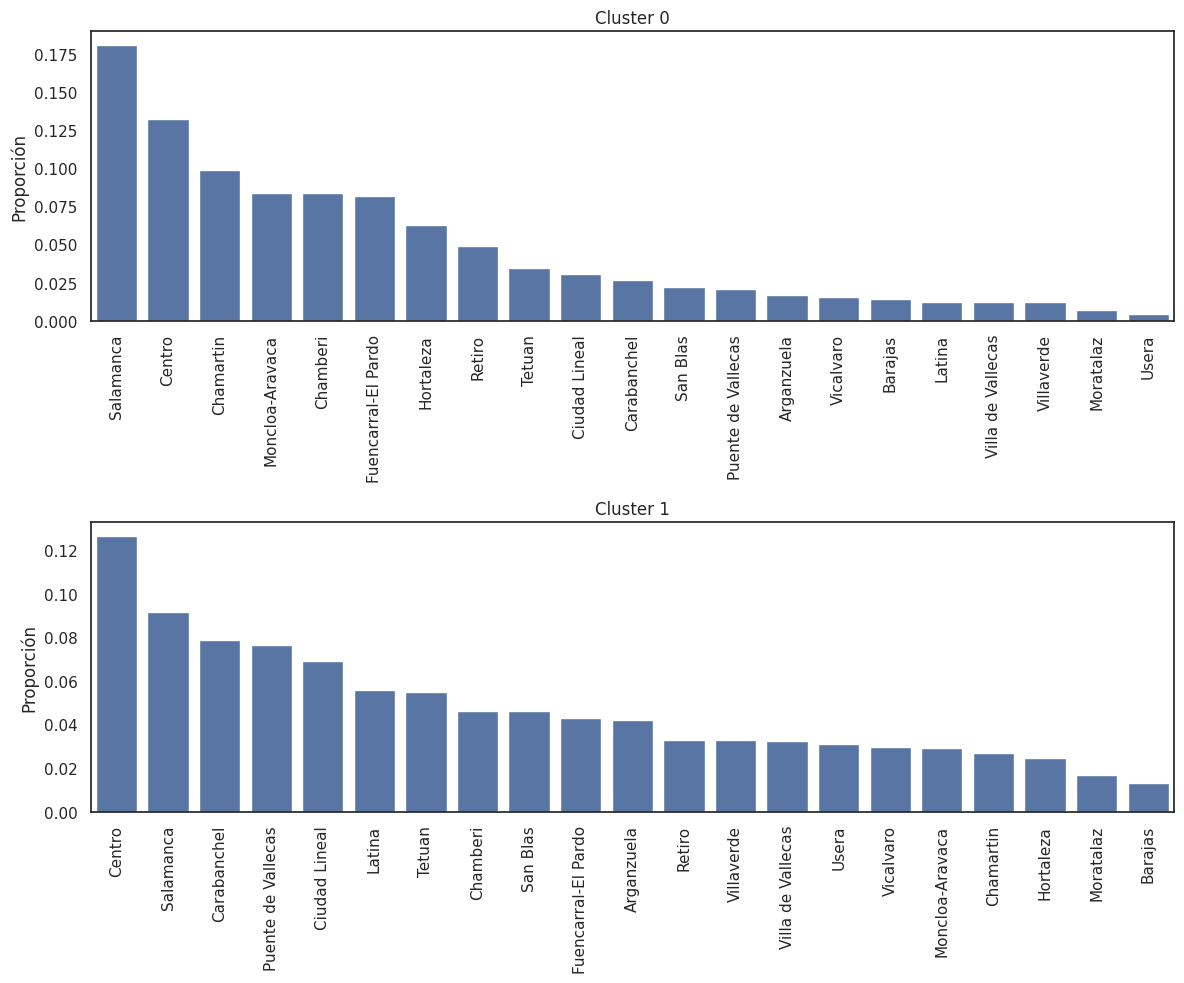

In [ ]:
plt.figure(figsize = (12, 10))
suma = 3
n_cluster = datos_cluster['ID'].unique()
for i in n_cluster:
    suma -= 1
    plt.subplot(2, 1, suma)
    datos_cluster_i = datos_cluster[datos_cluster['ID'] == i]
    cluster_i = datos_cluster_i.groupby(['cluster', 'distrito']).size().reset_index(name = 'tamaño')
    cluster_i['proporcion'] = cluster_i['tamaño']/sum(cluster_i['tamaño'])
    cluster_i.sort_values(by = 'proporcion', ascending = False, inplace = True)
    etiquetas_distrito = cluster_i['distrito'].unique()

    sns.barplot(data = cluster_i, x = etiquetas_distrito, y = 'proporcion')
    plt.xticks(rotation = 90)
    plt.ylabel('Proporción')
    plt.title(f'Cluster {i}')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Clustering/Graficos/Variables_Categoricas2_Cluster.png")
plt.show()

Obtenemos el conjunto de datos original excluyendo las variables **ID, distrito y tipo de vivienda**.

In [ ]:
datos_caracteristicas = datos_cluster.copy()
distrito_dummies = pd.get_dummies(datos_caracteristicas['distrito'], dtype = int)
vivienda_dummies = pd.get_dummies(datos_caracteristicas['tipo_vivienda'], dtype = int)
datos_car = pd.concat([datos_caracteristicas, distrito_dummies, vivienda_dummies], axis = 1)
datos_car.drop(['ID','distrito', 'tipo_vivienda'], axis = 1, inplace = True)

Podemos ver todas las caracteristicas medias de los 2 grupos resumidas en la siguiente tabla

In [ ]:
pd.reset_option('display.float_format')
X_medias = datos_car.groupby('cluster').mean()
X_medias.to_excel("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Clustering/Tablas/Caracteristicas_Medias.xlsx")
X_medias.head()

,precio,piscina,terraza,jardin,garaje,trastero,calefaccion,aire_acondicionado,ascensor,superficie_construida,...,Usera,Vicalvaro,Villa de Vallecas,Villaverde,Apartamento,Atico,Casa,Chalet,Duplex,Piso
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.277615e+06,0.245833,0.616667,0.245833,0.406944,0.412500,0.740278,0.595833,0.811111,198.197222,...,0.004167,0.015278,0.012500,0.012500,0.006944,0.055556,0.040278,0.054167,0.033333,0.809722
1,3.751684e+05,0.085742,0.374816,0.084272,0.151396,0.165605,0.539931,0.407153,0.564429,79.133464,...,0.030867,0.029887,0.032337,0.032827,0.020578,0.038707,0.006859,0.004900,0.015679,0.913278


Podemos ver todas las caracteristicas medianas de los 2 grupos resumidas en la siguiente tabla

In [ ]:
X_medianas = datos_car.groupby('cluster').median()
X_medianas.to_excel("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Clustering/Tablas/Caracteristicas_Medianas.xlsx")
X_medianas.head()

,precio,piscina,terraza,jardin,garaje,trastero,calefaccion,aire_acondicionado,ascensor,superficie_construida,...,Usera,Vicalvaro,Villa de Vallecas,Villaverde,Apartamento,Atico,Casa,Chalet,Duplex,Piso
cluster,,,,,,,,,,,,,,,,,,,,,
0,998000.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,170.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,275000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Tambien podemos ver intervalos de confianza para cada caracteristica de cada grupo.

Utilizamos intervalos de confianza basados en la distribucion t-student, pues el tamaño de cada grupo es n > 30.

In [ ]:
X_medias = datos_car.groupby('cluster').mean()
X_desv = datos_car.groupby('cluster').std()

Intervalo de confianza (IC) para el primer grupo.

In [ ]:
n = id.value_counts()[0]
media = X_medias.iloc[0]
desv = X_desv.iloc[0]
conf_level = 0.95
ic0 = func_tfg.intervalo_confianza(n, media, desv, conf_level)
ic0.loc['precio'] = ic0.loc['precio'].astype(float).apply(lambda x: '{:,.0f}'.format(x)).str.replace(',', '.')
ic0.to_excel("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Clustering/Tablas/IC0.xlsx")
ic0.head(40)

,Media,IC Inferior,IC Superior
precio,1.277.620,1.209.220,1.346.010
piscina,0.25,0.21,0.28
terraza,0.62,0.58,0.65
jardin,0.25,0.21,0.28
garaje,0.41,0.37,0.44
trastero,0.41,0.38,0.45
calefaccion,0.74,0.71,0.77
aire_acondicionado,0.6,0.56,0.63
ascensor,0.81,0.78,0.84
superficie_construida,198.2,191.41,204.99


Intervalo de confianza (IC) para el segundo grupo.

In [ ]:
n = id.value_counts()[1]
media = X_medias.iloc[1]
desv = X_desv.iloc[1]
conf_level = 0.95
ic1 = func_tfg.intervalo_confianza(n, media, desv, conf_level)
ic1.loc['precio'] = ic1.loc['precio'].astype(float).apply(lambda x: '{:,.0f}'.format(x)).str.replace(',', '.')
ic1.to_excel("/content/drive/MyDrive/TFG/Trabajo/Gráficos/Clustering/Tablas/IC1.xlsx")
ic1.head(40)

,Media,IC Inferior,IC Superior
precio,375.168,362.693,387.644
piscina,0.09,0.07,0.1
terraza,0.37,0.35,0.4
jardin,0.08,0.07,0.1
garaje,0.15,0.14,0.17
trastero,0.17,0.15,0.18
calefaccion,0.54,0.52,0.56
aire_acondicionado,0.41,0.39,0.43
ascensor,0.56,0.54,0.59
superficie_construida,79.13,77.94,80.33


## Guardar Archivo HTML

In [63]:
!pip install nbconvert

In [64]:
!jupyter nbconvert --to html Trabajo_Fin_Grado.ipynb

[NbConvertApp] Converting notebook Trabajo_Fin_Grado.ipynb to html
[NbConvertApp] Writing 3344175 bytes to Trabajo_Fin_Grado.html
